### Deep Reinforcement Learning for Base Station Policy Planning

In [1]:
# Environment Modules
import os, sys
sys.path.append('..')
from main import Env
from equipments import UE, BS
import matplotlib.pyplot as plt
from math import radians, pi, degrees
import numpy as np

In [2]:
engine_ip = 'localhost'
engine_port = 8877
SCENE_IMG = os.path.join(os.getcwd(), "../obj/pozin.png")
min_x = -143.236
max_x = 153.955
min_z = -140.049
max_z = 135.963

In [3]:
action_N = 4
state_N = 64
user_n = 10
t_per_ep = 20

In [4]:
# Machine Learning Modules
import collections
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple

In [5]:
actor_path = 'actor-model'
critic_path = 'critic-model'

In [6]:
seed = 8888
tf.random.set_seed(seed)
np.random.seed(seed)

eps = np.finfo(np.float32).eps.item()

In [8]:
class Environment:
    def __init__(self, ip, port):
        self.env = Env(ip, port)
        # min_tx / max_tx
        self.min_tx = 17
        self.max_tx = 23
        self.mpm_tx = self.max_tx+self.min_tx #max plus minus
        self.mmm_tx = self.max_tx-self.min_tx #max min minus
        # min_rx / max_tx
        self.min_rx = -90
        self.max_rx = -50
        self.mpm_rx = self.max_rx+self.min_rx
        self.mmm_rx = self.max_rx-self.min_rx
        # reward weight
        self.tx_weight = 0.4
        self.rec_weight = 0.6
        # steps
        self.current_step = 0
        self.total_rewards = []
        self.tx_rewards = []
        self.rx_rewards = []
        # create Scene
        # stations
        self.genScene()
        # end episode
        self.end_epi = t_per_ep
        self.state_N = state_N
    def __del__(self):
        try:
            self.disconnect()
        except:
            None
            
    def disconnect(self):
        self.env.disconnect()
        
    def genScene(self):
        self.env.reset()
        self.env.UEs = []
        self.env.BSs = []
        # BS
        bs_pos = [-74.583, 6, 48.17]
        bs_rotat = [0.5*pi,0,0]
        bs_freq = 4.2e9
        self.bs = BS(self.env, bs_pos, bs_rotat, bs_freq)
        self.bs.tx_pow = self.min_tx
        self.env.BSs.append(self.bs)
        
        for i in range(user_n):
            position = [0, -10, 0]
            while self.env.com.is_outdoor(position) is False:
                x = np.random.uniform(-60, 0)
                y = np.random.uniform(1.5, 2)
                z = np.random.uniform(0,57)
                position = [x,y,z]
            ue = UE(self.env, position)
            ue.connectTo(self.bs)
            ue.get_result()
            self.env.UEs.append(ue)
    
    def step(self, action):
        self.current_step += 1
        # action 1 - tx_power   2-harizon rotation
        if action == 0: # increase transmit power
            self.bs.tx_pow += 1
            self.bs.tx_pow = min(27, self.bs.tx_pow)
        if action == 1: # decrease transmit power
            self.bs.tx_pow -= 1
            self.bs.tx_pow = max(0, self.bs.tx_pow)
        if action == 2:  # rotate left by 10 degree
            angle = self.bs.rotation[0] + radians(10)
            self.bs.rotate([angle, self.bs.rotation[1], 0])
        if action == 3: # rotate right by 10 degree
            angle = self.bs.rotation[0] - radians(10)
            self.bs.rotate([angle, self.bs.rotation[1], 0])
        if action == 4: # rotate up
            angle = self.bs.rotation[1] + radians(10)
            self.bs.rotate([self.bs.rotation[0], angle, 0])
        if action == 5: # rotate down
            angle = self.bs.rotation[1] - radians(10)
            self.bs.rotate([self.bs.rotation[0], angle, 0])
        # get reward
        state = self.getState()
        reward = float(self.getReward())
        done = False
        if self.current_step >= self.end_epi:
            done = True
        return state, reward, done
    
    def getState(self):
        all_signals = []
        for us in self.env.UEs:
            all_signals += us.get_result()
        
        #all_signals.sort(key=lambda x: x['delay'], reverse=False)
        states = []
        for i in range(self.state_N-2):
            if i > len(all_signals)-1:
                states.append(0)
            else:
                if i % 2 == 0:
                    states.append(-all_signals[i]['pow']/200)
                else:
                    states.append(all_signals[i]['delay']/1000)
        states = [self.bs.tx_pow] + [self.bs.rotation[0]] + states
        return states
    
    def getReward(self):
        # Transmit Power
        tx_reward = (self.mpm_tx - 2*self.bs.tx_pow)/(self.mmm_tx)
        #print('current tx:' + str(self.bs.tx_pow))
        # limit higher reward
        #tx_reward = min(1, tx_reward)
        # Average Receive Power
        avg_rec = 0
        for ue in self.env.UEs:
            avg_rec += ue.total_rec
        avg_rec = avg_rec/len(self.env.UEs)
        print('avg rec:' + str(avg_rec))
        # Receiver Reward
        rx_reward = (2*avg_rec - self.mpm_rx)/self.mmm_rx
        # limit higher reward
        rx_reward = min(1,rx_reward)
        print("tx rew: {0} ,  avg rew: {1}".format(tx_reward, rx_reward))
        total_reward = self.tx_weight*tx_reward + self.rec_weight*rx_reward
        self.total_rewards.append(total_reward)
        self.tx_rewards.append(tx_reward)
        self.rx_rewards.append(rx_reward)
        return total_reward

In [9]:
class Critic(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.l1 = tf.keras.layers.Dense(state_N,activation='relu')
        self.l2 = tf.keras.layers.Dense(state_N/2,activation='relu')
        self.v = tf.keras.layers.Dense(1, activation = None)
        
    def call(self, input_):
        output_ = self.l1(input_)
        output_ = self.l2(output_)
        output_ = self.v(output_)
        return output_
    
class Actor(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.l1 = tf.keras.layers.Dense(state_N,activation='relu')
        self.l2 = tf.keras.layers.Dense(state_N/2,activation='relu')
        self.v = tf.keras.layers.Dense(action_N, activation = 'softmax')
        
    def call(self, input_):
        output_ = self.l1(input_)
        output_ = self.l2(output_)
        output_ = self.v(output_)
        return output_

In [10]:
class Agent():
    def __init__(self, gamma=0.99):
        self.gamma = gamma
        self.a_opt = tf.keras.optimizers.Adam(learning_rate=5e-6)
        self.c_opt = tf.keras.optimizers.Adam(learning_rate=5e-6)
        try:
            self.actor = tf.keras.models.load_model(actor_path, compile=False)
            self.critic = tf.keras.models.load_model(critic_path, compile=False)
            print("Loaded the saved model")
        except:
            print("Created the new model")
            self.actor = Actor()
            self.critic = Critic()
        
    def act(self, state):
        prob = self.actor(np.array([state]))
        print(prob)
        prob = prob.numpy()
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
        action = dist.sample()
        return int(action.numpy()[0])
    
    def actor_loss(self, prob, action, td):
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
        log_prob = dist.log_prob(action)
        loss = -log_prob*td
        return loss
    
    def learn(self, state, action, reward, next_state):
        state = np.array([state])
        next_state = np.array([next_state])
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            p = self.actor(state, training=True)
            v =  self.critic(state,training=True)
            vn = self.critic(next_state, training=True)
            td = reward + self.gamma*vn*(1-int(done)) - v
            a_loss = self.actor_loss(p, action, td)
            c_loss = td**2
        grads1 = tape1.gradient(a_loss, self.actor.trainable_variables)
        grads2 = tape2.gradient(c_loss, self.critic.trainable_variables)
        self.a_opt.apply_gradients(zip(grads1, self.actor.trainable_variables))
        self.c_opt.apply_gradients(zip(grads2, self.critic.trainable_variables))
        return a_loss, c_loss


## Train the agent

In [9]:
env = Environment(engine_ip, engine_port)
agent = Agent()
steps = 200
action_history = []
reward_history = []
state_history = []
i_train = 0
for s in range(steps):
    done = False
    env.genScene()
    env.current_step = 0
    state = env.getState()
    total_reward = 0
    al_aloss = []
    al_closs = []
    rewards = []
    actions = []
    while not done:
        actions = agent.act(state)
        action_history.append(actions)
        print('actions:'+ str(actions))
        print('cell: {0} dBm, theta: {1}, phi: {2}'.format(env.bs.tx_pow, degrees(env.bs.rotation[0]), degrees(env.bs.rotation[1])))
        #print(state)
        next_state, reward, done = env.step(actions)
        print('current reward:' + str(reward))
        reward_history.append(reward)
        a_loss, c_loss =  agent.learn(state, actions, reward, next_state)
        rewards.append(reward)
        al_aloss.append(a_loss)
        al_closs.append(c_loss)
        state = next_state
        i_train += 1
        if i_train <=100 or i_train >= 500:
            env.env.display_map(SCENE_IMG, SAVE_FILE = "DRL-{0}-{1}.png".format(seed, i_train), OFF=True )
env.disconnect()

Server: Hello Client 
tf.Tensor([[0.03002936 0.52504027 0.08053064 0.36439982]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-65.45461191207335
tx rew: 1.3333333333333333 ,  avg rew: 0.22726940439633267
current reward:0.6696949759711329
tf.Tensor([[0.03329637 0.52814436 0.08279388 0.35576537]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-66.45461191207333
tx rew: 1.6666666666666667 ,  avg rew: 0.17726940439633337
current reward:0.7730283093044668
tf.Tensor([[0.03684019 0.53084415 0.08519947 0.34711626]], shape=(1, 4), dtype=float32)
actions:2
cell: 15 dBm, theta: 90.0, phi: 0.0
avg rec:-78.27506667313418
tx rew: 1.6666666666666667 ,  avg rew: -0.41375333365670885
current reward:0.41841466647264147
tf.Tensor([[0.03858427 0.47866893 0.12371009 0.35903677]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 100.0, phi: 0.0
avg rec:-79.27506667313418
tx rew: 2.0 ,  avg rew: -0.46375333365670884
current

avg rec:-81.99751488971123
tx rew: 3.3333333333333335 ,  avg rew: -0.5998757444855614
current reward:0.9734078866419966
tf.Tensor([[0.08012753 0.47658387 0.12182225 0.3214664 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 10 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-82.99751488971124
tx rew: 3.6666666666666665 ,  avg rew: -0.6498757444855621
current reward:1.0767412199753297
tf.Tensor([[0.08939688 0.4643877  0.12841997 0.31779537]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-83.99751488971123
tx rew: 4.0 ,  avg rew: -0.6998757444855613
current reward:1.1800745533086632
tf.Tensor([[0.09891212 0.4500394  0.13610063 0.31494787]], shape=(1, 4), dtype=float32)
actions:0
cell: 8 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-82.99751488971124
tx rew: 3.6666666666666665 ,  avg rew: -0.6498757444855621
current reward:1.0767412199753297
tf.Tensor([[0.08939473 0.46445575 0.12841633 0.31773314]], shape=(1, 4), dtype=float32)
actions:

avg rec:-71.30240823605766
tx rew: 1.3333333333333333 ,  avg rew: -0.06512041180288293
current reward:0.4942610862516036
tf.Tensor([[0.03848084 0.53319466 0.0959958  0.33232862]], shape=(1, 4), dtype=float32)
actions:0
cell: 16 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-70.30240823605766
tx rew: 1.0 ,  avg rew: -0.015120411802882927
current reward:0.39092775291827025
tf.Tensor([[0.03357468 0.5374895  0.09108245 0.3378534 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-71.30240823605766
tx rew: 1.3333333333333333 ,  avg rew: -0.06512041180288293
current reward:0.4942610862516036
tf.Tensor([[0.03849969 0.53293943 0.09597213 0.33258885]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-69.60773632760065
tx rew: 1.3333333333333333 ,  avg rew: 0.0196131836199676
current reward:0.5451012435053139
tf.Tensor([[0.03763934 0.5704656  0.09591035 0.2959847 ]], shape=(1, 4), dtype=float32)
ac

avg rec:-82.0276984923695
tx rew: 3.6666666666666665 ,  avg rew: -0.6013849246184748
current reward:1.105835711895582
tf.Tensor([[0.05753129 0.47064248 0.12809531 0.34373096]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-83.0276984923695
tx rew: 4.0 ,  avg rew: -0.6513849246184747
current reward:1.2091690452289152
tf.Tensor([[0.06392007 0.46429813 0.13361704 0.33816478]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-84.0276984923695
tx rew: 4.333333333333333 ,  avg rew: -0.7013849246184748
current reward:1.3125023785622485
tf.Tensor([[0.02719903 0.5005743  0.0962686  0.37595814]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-75.10089471750562
tx rew: 1.0 ,  avg rew: -0.25504473587528126
current reward:0.24697315847483128
tf.Tensor([[0.02762431 0.5355658  0.10632199 0.33048785]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 80.0, ph

avg rec:-72.98788022666406
tx rew: 3.3333333333333335 ,  avg rew: -0.14939401133320301
current reward:1.2436969265334117
tf.Tensor([[0.09657727 0.4366476  0.17272405 0.29405108]], shape=(1, 4), dtype=float32)
actions:3
cell: 10 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-71.98786733569914
tx rew: 3.3333333333333335 ,  avg rew: -0.09939336678495678
current reward:1.2736973132623595
tf.Tensor([[0.08917833 0.43149954 0.18218598 0.29713622]], shape=(1, 4), dtype=float32)
actions:1
cell: 10 dBm, theta: 29.999999999999993, phi: 0.0
avg rec:-72.98786733569914
tx rew: 3.6666666666666665 ,  avg rew: -0.1493933667849568
current reward:1.3770306465956927
tf.Tensor([[0.09811424 0.42253673 0.18707372 0.2922753 ]], shape=(1, 4), dtype=float32)
actions:2
cell: 9 dBm, theta: 29.999999999999993, phi: 0.0
avg rec:-73.98788022666406
tx rew: 3.6666666666666665 ,  avg rew: -0.19939401133320303
current reward:1.347030259866745
tf.Tensor([[0.10281786 0.41853023 0.19167733 0.28697455]], shape=(1, 4), dty

avg rec:-75.81733979220326
tx rew: 2.3333333333333335 ,  avg rew: -0.29086698961016283
current reward:0.7588131395672357
tf.Tensor([[0.04687571 0.48689783 0.11755681 0.3486696 ]], shape=(1, 4), dtype=float32)
actions:2
cell: 13 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-77.67580224429233
tx rew: 2.3333333333333335 ,  avg rew: -0.3837901122146164
current reward:0.7030592660045636
tf.Tensor([[0.05293847 0.50425893 0.12515071 0.31765184]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 70.0, phi: 0.0
avg rec:-75.81733979220326
tx rew: 2.3333333333333335 ,  avg rew: -0.29086698961016283
current reward:0.7588131395672357
tf.Tensor([[0.05403906 0.4968675  0.12947556 0.3196179 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-73.96020832450333
tx rew: 2.3333333333333335 ,  avg rew: -0.19801041622516635
current reward:0.8145270835982337
tf.Tensor([[0.04903901 0.48646063 0.12336946 0.34113088]], shape=(1, 4), dtype=float32)
a

tf.Tensor([[0.03190952 0.5223414  0.08913112 0.35661802]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-71.99414533668933
tx rew: 1.3333333333333333 ,  avg rew: -0.09970726683446643
current reward:0.47350897323265345
tf.Tensor([[0.03656638 0.5192535  0.09217463 0.35200545]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-72.99414533668933
tx rew: 1.6666666666666667 ,  avg rew: -0.14970726683446642
current reward:0.5768423065659869
tf.Tensor([[0.04123222 0.5179152  0.09427186 0.34658068]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 90.0, phi: 0.0
avg rec:-73.99414533668933
tx rew: 2.0 ,  avg rew: -0.19970726683446643
current reward:0.6801756398993202
tf.Tensor([[0.04612519 0.51715755 0.09667719 0.3400401 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 14 dBm, theta: 90.0, phi: 0.0
avg rec:-85.12412483247398
tx rew: 2.0 ,  avg rew: -0.7562062416236991
current reward:0.34627625502578063
tf.Tensor

avg rec:-82.12283478974707
tx rew: 4.0 ,  avg rew: -0.6061417394873537
current reward:1.236314956307588
tf.Tensor([[0.08444426 0.42579073 0.1679694  0.3217956 ]], shape=(1, 4), dtype=float32)
actions:2
cell: 8 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-83.62002782841682
tx rew: 4.0 ,  avg rew: -0.6810013914208412
current reward:1.1913991651474953
tf.Tensor([[0.06855575 0.42821786 0.1340496  0.36917683]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-84.62002782841682
tx rew: 4.333333333333333 ,  avg rew: -0.7310013914208412
current reward:1.2947324984808286
tf.Tensor([[0.07833754 0.4144285  0.13948373 0.3677503 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-85.62002782841682
tx rew: 4.666666666666667 ,  avg rew: -0.7810013914208411
current reward:1.3980658318141623
tf.Tensor([[0.08972619 0.39377886 0.14208165 0.37441325]], shape=(1, 4), dtype=float32)
actions:1
cell: 6 dBm, thet

avg rec:-77.39329591199649
tx rew: 2.6666666666666665 ,  avg rew: -0.36966479559982446
current reward:0.844867789306772
tf.Tensor([[0.05351753 0.5230949  0.09596157 0.32742593]], shape=(1, 4), dtype=float32)
actions:2
cell: 12 dBm, theta: 70.0, phi: 0.0
avg rec:-79.25408776052738
tx rew: 2.6666666666666665 ,  avg rew: -0.46270438802636915
current reward:0.7890440338508451
tf.Tensor([[0.05789039 0.52771705 0.09754611 0.3168465 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 80.0, phi: 0.0
avg rec:-80.25408776052738
tx rew: 3.0 ,  avg rew: -0.5127043880263692
current reward:0.8923773671841786
tf.Tensor([[0.06509306 0.5230629  0.10250725 0.30933687]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 dBm, theta: 80.0, phi: 0.0
avg rec:-78.39329591199649
tx rew: 3.0 ,  avg rew: -0.41966479559982445
current reward:0.9482011226401055
tf.Tensor([[0.06784827 0.47346893 0.12857366 0.33010915]], shape=(1, 4), dtype=float32)
actions:2
cell: 11 dBm, theta: 70.0, phi: 0.0
avg rec:-80.

avg rec:-80.46004632852882
tx rew: 1.3333333333333333 ,  avg rew: -0.5230023164264409
current reward:0.2195319434774688
tf.Tensor([[0.03082127 0.52488714 0.08542415 0.35886747]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-79.01260041825054
tx rew: 1.3333333333333333 ,  avg rew: -0.45063002091252713
current reward:0.26295532078581707
tf.Tensor([[0.03564503 0.5432046  0.10643807 0.31471226]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 70.0, phi: 0.0
avg rec:-80.01260041825054
tx rew: 1.6666666666666667 ,  avg rew: -0.5006300209125272
current reward:0.36628865411915046
tf.Tensor([[0.04036199 0.54108804 0.11081979 0.30773014]], shape=(1, 4), dtype=float32)
actions:3
cell: 15 dBm, theta: 70.0, phi: 0.0
avg rec:-78.60123316431233
tx rew: 1.6666666666666667 ,  avg rew: -0.43006165821561665
current reward:0.40862967173729675
tf.Tensor([[0.03884088 0.54047775 0.11020248 0.31047884]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, t

avg rec:-81.67405567291632
tx rew: 4.0 ,  avg rew: -0.5837027836458162
current reward:1.2497783298125105
tf.Tensor([[0.07710677 0.46944514 0.13336413 0.32008398]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-82.67405567291631
tx rew: 4.333333333333333 ,  avg rew: -0.6337027836458156
current reward:1.3531116631458442
tf.Tensor([[0.08331961 0.4510179  0.14740776 0.31825468]], shape=(1, 4), dtype=float32)
actions:2
cell: 7 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-84.47097229209793
tx rew: 4.333333333333333 ,  avg rew: -0.7235486146048963
current reward:1.2992041645703956
tf.Tensor([[0.08986581 0.448884   0.1566897  0.30456048]], shape=(1, 4), dtype=float32)
actions:2
cell: 7 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-86.16632607196867
tx rew: 4.333333333333333 ,  avg rew: -0.8083163035984334
current reward:1.2483435511742733
tf.Tensor([[0.08562604 0.4669567  0.14961861 0.29779875]], shape=(1, 4), dtype=float32)
actions:2
ce

avg rec:-82.25351606220082
tx rew: 2.6666666666666665 ,  avg rew: -0.6126758031100408
current reward:0.6990611848006423
tf.Tensor([[0.04396591 0.5615933  0.10908495 0.2853558 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 80.0, phi: 0.0
avg rec:-83.25351606220082
tx rew: 3.0 ,  avg rew: -0.6626758031100408
current reward:0.8023945181339758
tf.Tensor([[0.04985514 0.5562793  0.11298878 0.28087682]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 80.0, phi: 0.0
avg rec:-84.25351606220083
tx rew: 3.3333333333333335 ,  avg rew: -0.7126758031100415
current reward:0.9057278514673086
tf.Tensor([[0.05585819 0.55185485 0.11559587 0.27669105]], shape=(1, 4), dtype=float32)
actions:0
cell: 10 dBm, theta: 80.0, phi: 0.0
avg rec:-83.25351606220082
tx rew: 3.0 ,  avg rew: -0.6626758031100408
current reward:0.8023945181339758
tf.Tensor([[0.04986057 0.55639887 0.11298316 0.28075743]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 dBm, theta: 80.0, phi: 0.0
avg rec:-81.96

tf.Tensor([[0.02474684 0.51019484 0.08459005 0.38046825]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-72.41639343648657
tx rew: 1.3333333333333333 ,  avg rew: -0.12081967182432862
current reward:0.46084153023873614
tf.Tensor([[0.02805154 0.5121035  0.08647956 0.37336528]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-86.23612264980831
tx rew: 1.3333333333333333 ,  avg rew: -0.8118061324904154
current reward:0.04624965383908408
tf.Tensor([[0.03335469 0.5346756  0.08169126 0.35027844]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-87.2361226498083
tx rew: 1.6666666666666667 ,  avg rew: -0.8618061324904147
current reward:0.1495829871724179
tf.Tensor([[0.03795956 0.5329718  0.08416646 0.34490222]], shape=(1, 4), dtype=float32)
actions:2
cell: 15 dBm, theta: 80.0, phi: 0.0
avg rec:-89.07136948285503
tx rew: 1.6666666666666667 ,  avg rew: -0.9535684741427517
current reward:0

avg rec:-81.22190706967572
tx rew: 2.6666666666666665 ,  avg rew: -0.5610953534837861
current reward:0.730009454576395
tf.Tensor([[0.04421566 0.5230695  0.11377235 0.31894252]], shape=(1, 4), dtype=float32)
actions:3
cell: 12 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-79.56652485710364
tx rew: 2.6666666666666665 ,  avg rew: -0.4783262428551822
current reward:0.7796709209535573
tf.Tensor([[0.05403267 0.4883622  0.12914827 0.32845688]], shape=(1, 4), dtype=float32)
actions:3
cell: 12 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-78.02645085110613
tx rew: 2.6666666666666665 ,  avg rew: -0.4013225425553067
current reward:0.8258731411334826
tf.Tensor([[0.05344014 0.46615437 0.14034034 0.34006518]], shape=(1, 4), dtype=float32)
actions:3
cell: 12 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-76.57009632424463
tx rew: 2.6666666666666665 ,  avg rew: -0.32850481621223154
current reward:0.8695637769393277
tf.Tensor([[0.05710724 0.48048037 0.13674581 0.32566655]], shape=(1, 4), dtype=

avg rec:-72.43088353207327
tx rew: 1.6666666666666667 ,  avg rew: -0.12154417660366335
current reward:0.5937401607044688
tf.Tensor([[0.04348777 0.5015245  0.09737328 0.35761443]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-73.43088353207327
tx rew: 2.0 ,  avg rew: -0.17154417660366333
current reward:0.697073494037802
tf.Tensor([[0.04990664 0.49391675 0.10278016 0.35339645]], shape=(1, 4), dtype=float32)
actions:2
cell: 14 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-75.0260559099253
tx rew: 2.0 ,  avg rew: -0.2513027954962652
current reward:0.6492183227022409
tf.Tensor([[0.05159588 0.5244106  0.08931339 0.33468017]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 70.0, phi: 0.0
avg rec:-76.0260559099253
tx rew: 2.3333333333333335 ,  avg rew: -0.3013027954962652
current reward:0.7525516560355743
tf.Tensor([[0.05923234 0.51574606 0.09436736 0.33065417]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 70.0

avg rec:-82.98895881512689
tx rew: 4.0 ,  avg rew: -0.6494479407563446
current reward:1.2103312355461933
tf.Tensor([[0.02679129 0.5126916  0.09754752 0.36296964]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-64.95500761324013
tx rew: 1.3333333333333333 ,  avg rew: 0.2522496193379936
current reward:0.6846831049361295
tf.Tensor([[0.03076911 0.50972325 0.1008441  0.35866347]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-65.95500761324013
tx rew: 1.6666666666666667 ,  avg rew: 0.20224961933799362
current reward:0.7880164382694629
tf.Tensor([[0.03530987 0.5064185  0.10416604 0.3541056 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 90.0, phi: 0.0
avg rec:-66.95500761324013
tx rew: 2.0 ,  avg rew: 0.15224961933799364
current reward:0.8913497716027963
tf.Tensor([[0.04048556 0.50273234 0.1075002  0.3492819 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 14 dBm, theta: 90.0, phi: 0.0
avg rec:-79.267

avg rec:-79.32335524993871
tx rew: 3.6666666666666665 ,  avg rew: -0.4661677624969357
current reward:1.1869660091685055
tf.Tensor([[0.0631427  0.5463527  0.11144423 0.2790605 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 80.0, phi: 0.0
avg rec:-80.32335524993871
tx rew: 4.0 ,  avg rew: -0.5161677624969357
current reward:1.2902993425018385
tf.Tensor([[0.06615772 0.5359853  0.11963364 0.2782234 ]], shape=(1, 4), dtype=float32)
actions:2
cell: 8 dBm, theta: 80.0, phi: 0.0
avg rec:-82.08033407055277
tx rew: 4.0 ,  avg rew: -0.6040167035276383
current reward:1.2375899778834172
tf.Tensor([[0.06696492 0.51712674 0.12293126 0.29297706]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 90.0, phi: 0.0
avg rec:-83.08033407055277
tx rew: 4.333333333333333 ,  avg rew: -0.6540167035276383
current reward:1.3409233112167505
tf.Tensor([[0.07008845 0.50848347 0.1326282  0.28879988]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, theta: 90.0, phi: 0.0
avg rec:-84.0803340

avg rec:-75.54843856602533
tx rew: 2.0 ,  avg rew: -0.2774219283012663
current reward:0.6335468430192402
tf.Tensor([[0.03693365 0.5214084  0.09535722 0.34630075]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 70.0, phi: 0.0
avg rec:-76.54843856602533
tx rew: 2.3333333333333335 ,  avg rew: -0.32742192830126626
current reward:0.7368801763525737
tf.Tensor([[0.04173381 0.5186137  0.09759987 0.3420526 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 70.0, phi: 0.0
avg rec:-77.54843856602534
tx rew: 2.6666666666666665 ,  avg rew: -0.377421928301267
current reward:0.8402135096859065
tf.Tensor([[0.04759892 0.5124658  0.1008541  0.33908114]], shape=(1, 4), dtype=float32)
actions:3
cell: 12 dBm, theta: 70.0, phi: 0.0
avg rec:-76.10362413378772
tx rew: 2.6666666666666665 ,  avg rew: -0.3051812066893859
current reward:0.8835579426530351
tf.Tensor([[0.04888593 0.46705908 0.14455044 0.33950454]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 59.99999999999

avg rec:-79.64386498567202
tx rew: 4.0 ,  avg rew: -0.48219324928360124
current reward:1.3106840504298394
tf.Tensor([[0.02780351 0.51986265 0.10394948 0.34838438]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-62.73237227682701
tx rew: 1.3333333333333333 ,  avg rew: 0.3633813861586496
current reward:0.7513621650285232
tf.Tensor([[0.03175908 0.5128983  0.11068438 0.3446582 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-72.62983268969353
tx rew: 1.3333333333333333 ,  avg rew: -0.13149163448467646
current reward:0.45443835264252747
tf.Tensor([[0.03997898 0.53451574 0.09091842 0.33458686]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-70.86255371752559
tx rew: 1.3333333333333333 ,  avg rew: -0.043127685876279284
current reward:0.5074567218075657
tf.Tensor([[0.03488869 0.5386311  0.11676461 0.30971566]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 70.0, phi:

avg rec:-80.69565222756208
tx rew: 2.3333333333333335 ,  avg rew: -0.5347826113781039
current reward:0.6124637665064712
tf.Tensor([[0.04624971 0.52364594 0.10908838 0.32101598]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-81.69565222756208
tx rew: 2.6666666666666665 ,  avg rew: -0.584782611378104
current reward:0.7157970998398042
tf.Tensor([[0.05186711 0.5193617  0.1125978  0.31617343]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-82.69565222756206
tx rew: 3.0 ,  avg rew: -0.6347826113781032
current reward:0.8191304331731383
tf.Tensor([[0.05831318 0.5123777  0.11795132 0.31135783]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-81.41799941685179
tx rew: 3.0 ,  avg rew: -0.5708999708425893
current reward:0.8574600174944467
tf.Tensor([[0.05107801 0.48373482 0.14310212 0.32208505]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm

avg rec:-71.4056418330345
tx rew: 2.3333333333333335 ,  avg rew: -0.07028209165172469
current reward:0.8911640783422986
tf.Tensor([[0.06236029 0.49309814 0.11369085 0.33085075]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-72.4056418330345
tx rew: 2.6666666666666665 ,  avg rew: -0.1202820916517247
current reward:0.9944974116756319
tf.Tensor([[0.07071658 0.48715225 0.11743394 0.32469726]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-73.4056418330345
tx rew: 3.0 ,  avg rew: -0.1702820916517247
current reward:1.0978307450089653
tf.Tensor([[0.07947363 0.48201376 0.12213483 0.31637776]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-71.92005688701616
tx rew: 3.0 ,  avg rew: -0.09600284435080794
current reward:1.1423982933895154
tf.Tensor([[0.08088541 0.47347406 0.11184493 0.33379564]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm

avg rec:-79.35874869230466
tx rew: 2.6666666666666665 ,  avg rew: -0.4679374346152329
current reward:0.785904205897527
tf.Tensor([[0.04677008 0.5214281  0.10183058 0.32997116]], shape=(1, 4), dtype=float32)
actions:3
cell: 12 dBm, theta: 80.0, phi: 0.0
avg rec:-77.99764750615233
tx rew: 2.6666666666666665 ,  avg rew: -0.39988237530761667
current reward:0.8267372414820966
tf.Tensor([[0.05319604 0.5133449  0.11072151 0.32273754]], shape=(1, 4), dtype=float32)
actions:3
cell: 12 dBm, theta: 70.0, phi: 0.0
avg rec:-76.7207108848592
tx rew: 2.6666666666666665 ,  avg rew: -0.33603554424296006
current reward:0.8650453401208906
tf.Tensor([[0.0481342  0.53575283 0.11910526 0.29700774]], shape=(1, 4), dtype=float32)
actions:3
cell: 12 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-75.49192941475832
tx rew: 2.6666666666666665 ,  avg rew: -0.2745964707379159
current reward:0.9019087842239171
tf.Tensor([[0.05524207 0.5126336  0.10670256 0.32542178]], shape=(1, 4), dtype=float32)
actions:3
cell: 1

avg rec:-83.02889886234655
tx rew: 5.0 ,  avg rew: -0.6514449431173276
current reward:1.6091330341296035
tf.Tensor([[0.07221565 0.46155185 0.15794119 0.30829132]], shape=(1, 4), dtype=float32)
actions:2
cell: 5 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-84.13258014307746
tx rew: 5.0 ,  avg rew: -0.7066290071538731
current reward:1.576022595707676
tf.Tensor([[0.02429065 0.5002216  0.08670445 0.3887833 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-80.59995942214519
tx rew: 1.0 ,  avg rew: -0.5299979711072595
current reward:0.0820012173356443
tf.Tensor([[0.0227968  0.50672925 0.09451061 0.37596333]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-78.6431063376346
tx rew: 1.0 ,  avg rew: -0.4321553168817303
current reward:0.14070680987096185
tf.Tensor([[0.02386028 0.4991396  0.0965895  0.38041067]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 70.0, phi: 0.0
avg rec:-79.6431063376346
tx rew:

avg rec:-85.6290064247954
tx rew: 3.6666666666666665 ,  avg rew: -0.7814503212397703
current reward:0.9977964739228047
tf.Tensor([[0.08183365 0.52941346 0.12902266 0.25973022]], shape=(1, 4), dtype=float32)
actions:3
cell: 9 dBm, theta: 110.0, phi: 0.0
avg rec:-84.25134874779634
tx rew: 3.6666666666666665 ,  avg rew: -0.7125674373898171
current reward:1.0391262042327765
tf.Tensor([[0.09571736 0.46913335 0.14281064 0.2923386 ]], shape=(1, 4), dtype=float32)
actions:0
cell: 9 dBm, theta: 100.0, phi: 0.0
avg rec:-83.25134874779634
tx rew: 3.3333333333333335 ,  avg rew: -0.6625674373898172
current reward:0.9357928708994432
tf.Tensor([[0.08525012 0.4821063  0.13596389 0.29667968]], shape=(1, 4), dtype=float32)
actions:3
cell: 10 dBm, theta: 100.0, phi: 0.0
avg rec:-81.7827186792725
tx rew: 3.3333333333333335 ,  avg rew: -0.5891359339636253
current reward:0.9798517729551584
tf.Tensor([[0.07364353 0.49701682 0.14076495 0.28857467]], shape=(1, 4), dtype=float32)
actions:3
cell: 10 dBm, theta: 

avg rec:-84.62636944319381
tx rew: 2.6666666666666665 ,  avg rew: -0.7313184721596905
current reward:0.6278755833708524
tf.Tensor([[0.04589064 0.524248   0.11269837 0.31716293]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 90.0, phi: 0.0
avg rec:-85.62636944319381
tx rew: 3.0 ,  avg rew: -0.7813184721596904
current reward:0.731208916704186
tf.Tensor([[0.05094786 0.51919615 0.11845347 0.31140253]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 90.0, phi: 0.0
avg rec:-86.62636944319381
tx rew: 3.3333333333333335 ,  avg rew: -0.8313184721596905
current reward:0.8345422500375193
tf.Tensor([[0.05718917 0.5098877  0.12592123 0.30700192]], shape=(1, 4), dtype=float32)
actions:2
cell: 10 dBm, theta: 90.0, phi: 0.0
avg rec:-88.38220514981622
tx rew: 3.3333333333333335 ,  avg rew: -0.9191102574908108
current reward:0.781867178838847
tf.Tensor([[0.0599942  0.5126748  0.11923393 0.30809706]], shape=(1, 4), dtype=float32)
actions:3
cell: 10 dBm, theta: 100.0, phi: 0.0


avg rec:-72.06412798037326
tx rew: 3.3333333333333335 ,  avg rew: -0.10320639901866287
current reward:1.2714094939221359
tf.Tensor([[0.07737395 0.44064456 0.1470841  0.3348974 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 10 dBm, theta: 9.999999999999991, phi: 0.0
avg rec:-73.06412798037326
tx rew: 3.6666666666666665 ,  avg rew: -0.15320639901866287
current reward:1.3747428272554691
tf.Tensor([[0.02495944 0.5208659  0.08998645 0.36418813]], shape=(1, 4), dtype=float32)
actions:2
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-79.66018951342207
tx rew: 1.0 ,  avg rew: -0.4830094756711034
current reward:0.11019431459733797
tf.Tensor([[0.02478727 0.55422354 0.06351981 0.35746935]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 100.0, phi: 0.0
avg rec:-77.71738990839783
tx rew: 1.0 ,  avg rew: -0.3858694954198917
current reward:0.16847830274806502
tf.Tensor([[0.02896022 0.49229786 0.08071375 0.39802814]], shape=(1, 4), dtype=float32)
actions:0
cell: 17 dBm, theta: 90.0, phi: 

avg rec:-71.66676955841046
tx rew: 3.3333333333333335 ,  avg rew: -0.08333847792052325
current reward:1.2833302465810195
tf.Tensor([[0.06362003 0.49207482 0.13409747 0.31020772]], shape=(1, 4), dtype=float32)
actions:3
cell: 10 dBm, theta: 19.99999999999999, phi: 0.0
avg rec:-70.74065421486033
tx rew: 3.3333333333333335 ,  avg rew: -0.037032710743016395
current reward:1.3111137068875236
tf.Tensor([[0.08800327 0.4621602  0.15382667 0.29600987]], shape=(1, 4), dtype=float32)
actions:3
cell: 10 dBm, theta: 9.999999999999991, phi: 0.0
avg rec:-70.22079362146539
tx rew: 3.3333333333333335 ,  avg rew: -0.011039681073269492
current reward:1.3267095246893719
tf.Tensor([[0.090459   0.42693466 0.17040272 0.31220356]], shape=(1, 4), dtype=float32)
actions:1
cell: 10 dBm, theta: -9.54166404439055e-15, phi: 0.0
avg rec:-71.22079362146539
tx rew: 3.6666666666666665 ,  avg rew: -0.06103968107326949
current reward:1.4300428580227051
tf.Tensor([[0.09982951 0.4122326  0.17921981 0.30871803]], shape=(1, 

avg rec:-73.92910918085427
tx rew: 3.3333333333333335 ,  avg rew: -0.19645545904271344
current reward:1.2154600579077055
tf.Tensor([[0.05188816 0.5702773  0.09603737 0.28179723]], shape=(1, 4), dtype=float32)
actions:3
cell: 10 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-72.52109772974816
tx rew: 3.3333333333333335 ,  avg rew: -0.12605488648740817
current reward:1.2577004014408886
tf.Tensor([[0.06036612 0.55475694 0.09821022 0.28666672]], shape=(1, 4), dtype=float32)
actions:1
cell: 10 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-73.52109772974815
tx rew: 3.6666666666666665 ,  avg rew: -0.17605488648740747
current reward:1.3610337347742223
tf.Tensor([[0.06463235 0.5454762  0.10568009 0.2842114 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-74.52109772974815
tx rew: 4.0 ,  avg rew: -0.22605488648740746
current reward:1.4643670681075556
tf.Tensor([[0.06864058 0.5352664  0.11319954 0.28289348]], shape=(1, 4), dtype=float32)
act

avg rec:-71.05046187195589
tx rew: 2.0 ,  avg rew: -0.05252309359779446
current reward:0.7684861438413234
tf.Tensor([[0.04148167 0.52729803 0.12232257 0.30889773]], shape=(1, 4), dtype=float32)
actions:3
cell: 14 dBm, theta: 70.0, phi: 0.0
avg rec:-69.78619058575457
tx rew: 2.0 ,  avg rew: 0.010690470712271605
current reward:0.806414282427363
tf.Tensor([[0.03880973 0.5321254  0.09406146 0.3350034 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 14 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-68.765148280782
tx rew: 2.0 ,  avg rew: 0.06174258596089999
current reward:0.83704555157654
tf.Tensor([[0.04368957 0.51579833 0.11932269 0.32118937]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-69.765148280782
tx rew: 2.3333333333333335 ,  avg rew: 0.011742585960899988
current reward:0.9403788849098734
tf.Tensor([[0.04992058 0.51175827 0.12205404 0.3162672 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 49.99999999999999, phi

avg rec:-87.05088287075566
tx rew: 5.0 ,  avg rew: -0.8525441435377829
current reward:1.4884735138773304
tf.Tensor([[0.02641866 0.52740973 0.08233629 0.36383528]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-76.41401016215997
tx rew: 1.0 ,  avg rew: -0.32070050810799844
current reward:0.20757969513520097
tf.Tensor([[0.03038551 0.5704983  0.08178698 0.31732914]], shape=(1, 4), dtype=float32)
actions:0
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-75.41401016215994
tx rew: 0.6666666666666666 ,  avg rew: -0.270700508107997
current reward:0.10424636180186847
tf.Tensor([[0.02647705 0.5755682  0.0788158  0.31913897]], shape=(1, 4), dtype=float32)
actions:1
cell: 18 dBm, theta: 80.0, phi: 0.0
avg rec:-76.41401016215997
tx rew: 1.0 ,  avg rew: -0.32070050810799844
current reward:0.20757969513520097
tf.Tensor([[0.03038398 0.5705212  0.08180042 0.31729442]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-77.4140101621599

avg rec:-84.89755684825953
tx rew: 4.0 ,  avg rew: -0.7448778424129763
current reward:1.1530732945522144
tf.Tensor([[0.0714443  0.47679877 0.13221955 0.3195373 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 8 dBm, theta: 80.0, phi: 0.0
avg rec:-83.09458361257977
tx rew: 4.0 ,  avg rew: -0.6547291806289884
current reward:1.207162491622607
tf.Tensor([[0.07180211 0.4663047  0.15022741 0.3116657 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 70.0, phi: 0.0
avg rec:-84.09458361257977
tx rew: 4.333333333333333 ,  avg rew: -0.7047291806289884
current reward:1.3104958249559404
tf.Tensor([[0.07631562 0.45456994 0.16041619 0.30869836]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, theta: 70.0, phi: 0.0
avg rec:-85.09458361257977
tx rew: 4.666666666666667 ,  avg rew: -0.7547291806289884
current reward:1.413829158289274
tf.Tensor([[0.07992244 0.44360498 0.170364   0.30610862]], shape=(1, 4), dtype=float32)
actions:2
cell: 6 dBm, theta: 70.0, phi: 0.0
avg rec:-86.8975568482

avg rec:-80.0943741715164
tx rew: 2.3333333333333335 ,  avg rew: -0.5047187085758204
current reward:0.6305021081878412
tf.Tensor([[0.04147407 0.52804506 0.09558003 0.33490077]], shape=(1, 4), dtype=float32)
actions:2
cell: 13 dBm, theta: 80.0, phi: 0.0
avg rec:-82.11602446806407
tx rew: 2.3333333333333335 ,  avg rew: -0.6058012234032034
current reward:0.5698525992914114
tf.Tensor([[0.02874974 0.59607226 0.08598323 0.2891948 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 90.0, phi: 0.0
avg rec:-83.11602446806407
tx rew: 2.6666666666666665 ,  avg rew: -0.6558012234032035
current reward:0.6731859326247446
tf.Tensor([[0.03273781 0.5907485  0.09172229 0.2847914 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 90.0, phi: 0.0
avg rec:-84.11602446806407
tx rew: 3.0 ,  avg rew: -0.7058012234032034
current reward:0.7765192659580782
tf.Tensor([[0.03720588 0.5811528  0.09771428 0.28392696]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 90.0, phi: 0.0


avg rec:-82.06517474150117
tx rew: 4.333333333333333 ,  avg rew: -0.6032587370750584
current reward:1.3713780910882984
tf.Tensor([[0.02209868 0.55908555 0.0786208  0.34019497]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-72.82214600676555
tx rew: 1.0 ,  avg rew: -0.1411073003382775
current reward:0.3153356197970335
tf.Tensor([[0.02584836 0.55807143 0.07993667 0.33614358]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-71.26208717975601
tx rew: 1.0 ,  avg rew: -0.06310435898780042
current reward:0.36213738460731976
tf.Tensor([[0.02699675 0.54548895 0.08322188 0.34429234]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 70.0, phi: 0.0
avg rec:-72.26208717975601
tx rew: 1.3333333333333333 ,  avg rew: -0.11310435898780043
current reward:0.4654707179406531
tf.Tensor([[0.03110176 0.54205877 0.08629452 0.34054494]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 70.0, phi: 0.0
avg rec:-73.

avg rec:-82.57605858998599
tx rew: 3.3333333333333335 ,  avg rew: -0.6288029294992995
current reward:0.9560515756337538
tf.Tensor([[0.06054228 0.4994674  0.11725236 0.32273793]], shape=(1, 4), dtype=float32)
actions:2
cell: 10 dBm, theta: 90.0, phi: 0.0
avg rec:-84.10267589776335
tx rew: 3.3333333333333335 ,  avg rew: -0.7051337948881674
current reward:0.910253056400433
tf.Tensor([[0.06320085 0.5141639  0.10732022 0.31531498]], shape=(1, 4), dtype=float32)
actions:1
cell: 10 dBm, theta: 100.0, phi: 0.0
avg rec:-85.10267589776335
tx rew: 3.6666666666666665 ,  avg rew: -0.7551337948881673
current reward:1.0135863897337665
tf.Tensor([[0.06716154 0.5024344  0.11761671 0.3127874 ]], shape=(1, 4), dtype=float32)
actions:2
cell: 9 dBm, theta: 100.0, phi: 0.0
avg rec:-86.8855946160754
tx rew: 3.6666666666666665 ,  avg rew: -0.8442797308037697
current reward:0.960098828184405
tf.Tensor([[0.06258523 0.5156147  0.11936898 0.30243105]], shape=(1, 4), dtype=float32)
actions:2
cell: 9 dBm, theta: 11

avg rec:-70.18707047766911
tx rew: 1.0 ,  avg rew: -0.009353523883455495
current reward:0.3943878856699267
tf.Tensor([[0.02974507 0.5106786  0.09301145 0.36656487]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-68.56287306449462
tx rew: 1.0 ,  avg rew: 0.07185634677526878
current reward:0.4431138080651613
tf.Tensor([[0.03162163 0.5024883  0.11239249 0.35349765]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-69.56287306449462
tx rew: 1.3333333333333333 ,  avg rew: 0.021856346775268775
current reward:0.5464471413984946
tf.Tensor([[0.03576322 0.50195843 0.11557364 0.34670475]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-68.04037551999161
tx rew: 1.3333333333333333 ,  avg rew: 0.09798122400041934
current reward:0.5921220677335849
tf.Tensor([[0.03711318 0.51846606 0.10916499 0.33525574]], shape=(1, 4), dtype=float32)
actions:1
cell: 16

tf.Tensor([[0.02516136 0.55811435 0.0896811  0.3270432 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-76.55523516062797
tx rew: 1.0 ,  avg rew: -0.3277617580313986
current reward:0.20334294518116086
tf.Tensor([[0.02666358 0.5598967  0.07428452 0.3391552 ]], shape=(1, 4), dtype=float32)
actions:2
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-78.4459625590378
tx rew: 1.0 ,  avg rew: -0.42229812795188976
current reward:0.14662112322886617
tf.Tensor([[0.02469884 0.58019596 0.07217896 0.3229262 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-79.4459625590378
tx rew: 1.3333333333333333 ,  avg rew: -0.47229812795188975
current reward:0.2499544565621995
tf.Tensor([[0.02875629 0.5732959  0.07601282 0.32193494]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-77.55523516062797
tx rew: 1.3333333333333333 ,  avg rew: -0.37776175803139866
current reward:0.30667627851449414
tf.Tensor(

avg rec:-81.49940788077039
tx rew: 4.0 ,  avg rew: -0.5749703940385196
current reward:1.2550177635768884
tf.Tensor([[0.07755208 0.46517506 0.15530646 0.3019664 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 8 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-79.70159189445958
tx rew: 4.0 ,  avg rew: -0.4850795947229791
current reward:1.3089522431662126
tf.Tensor([[0.08631149 0.44682398 0.16729218 0.2995724 ]], shape=(1, 4), dtype=float32)
actions:2
cell: 8 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-81.49940788077039
tx rew: 4.0 ,  avg rew: -0.5749703940385196
current reward:1.2550177635768884
tf.Tensor([[0.08587657 0.46255445 0.16419907 0.28736997]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-82.49940788077039
tx rew: 4.333333333333333 ,  avg rew: -0.6249703940385196
current reward:1.3583510969102217
tf.Tensor([[0.02281648 0.5347106  0.08878756 0.35368532]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi

avg rec:-75.87960951916031
tx rew: 1.6666666666666667 ,  avg rew: -0.2939804759580156
current reward:0.4902783810918574
tf.Tensor([[0.04146506 0.54963857 0.08502034 0.32387602]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 90.0, phi: 0.0
avg rec:-76.87960951916031
tx rew: 2.0 ,  avg rew: -0.34398047595801556
current reward:0.5936117144251907
tf.Tensor([[0.04709062 0.5453125  0.08949008 0.31810677]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 90.0, phi: 0.0
avg rec:-77.87960951916031
tx rew: 2.3333333333333335 ,  avg rew: -0.39398047595801555
current reward:0.6969450477585242
tf.Tensor([[0.05396876 0.5362881  0.09566293 0.31408024]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 90.0, phi: 0.0
avg rec:-78.87960951916031
tx rew: 2.6666666666666665 ,  avg rew: -0.4439804759580156
current reward:0.8002783810918572
tf.Tensor([[0.06171133 0.5257376  0.10257055 0.3099805 ]], shape=(1, 4), dtype=float32)
actions:2
cell: 12 dBm, theta: 90.0, phi: 0

avg rec:-79.03625918527868
tx rew: 1.3333333333333333 ,  avg rew: -0.45181295926393406
current reward:0.2622455577749729
tf.Tensor([[0.02371965 0.5441863  0.08028316 0.35181096]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-80.03625918527868
tx rew: 1.6666666666666667 ,  avg rew: -0.501812959263934
current reward:0.3655788911083064
tf.Tensor([[0.02713851 0.54107815 0.08466882 0.34711456]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 90.0, phi: 0.0
avg rec:-81.03625918527868
tx rew: 2.0 ,  avg rew: -0.551812959263934
current reward:0.46891222444163966
tf.Tensor([[0.03101208 0.5375661  0.08923454 0.34218717]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 90.0, phi: 0.0
avg rec:-82.03625918527868
tx rew: 2.3333333333333335 ,  avg rew: -0.6018129592639341
current reward:0.572245557774973
tf.Tensor([[0.03523796 0.5352774  0.09424842 0.33523613]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 90.0, phi: 0.0


avg rec:-77.78684087891942
tx rew: 4.333333333333333 ,  avg rew: -0.38934204394597105
current reward:1.4997281069657507
tf.Tensor([[0.09960853 0.47980207 0.16633853 0.25425085]], shape=(1, 4), dtype=float32)
actions:3
cell: 7 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-76.62625636946741
tx rew: 4.333333333333333 ,  avg rew: -0.33131281847337063
current reward:1.5345456422493111
tf.Tensor([[0.10451322 0.46682385 0.17369646 0.2549665 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 7 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-75.54118877251098
tx rew: 4.333333333333333 ,  avg rew: -0.2770594386255489
current reward:1.5670976701580042
tf.Tensor([[0.08781778 0.47723687 0.16359948 0.27134585]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, theta: 29.999999999999993, phi: 0.0
avg rec:-76.54118877251099
tx rew: 4.666666666666667 ,  avg rew: -0.3270594386255496
current reward:1.6704310034913372
tf.Tensor([[0.09140322 0.4638665  0.17290655 0.2718238 ]], shape=(1, 4), dtype=floa

avg rec:-85.32443064175098
tx rew: 2.3333333333333335 ,  avg rew: -0.766221532087549
current reward:0.4736004140808041
tf.Tensor([[0.05084768 0.49247694 0.10460807 0.35206735]], shape=(1, 4), dtype=float32)
actions:0
cell: 13 dBm, theta: 70.0, phi: 0.0
avg rec:-84.32443064175098
tx rew: 2.0 ,  avg rew: -0.7162215320875489
current reward:0.3702670807474707
tf.Tensor([[0.04438112 0.49841243 0.1008957  0.35631076]], shape=(1, 4), dtype=float32)
actions:3
cell: 14 dBm, theta: 70.0, phi: 0.0
avg rec:-82.41957216120244
tx rew: 2.0 ,  avg rew: -0.620978608060122
current reward:0.42741283516392686
tf.Tensor([[0.04233243 0.4824954  0.11625788 0.35891423]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-83.41957216120244
tx rew: 2.3333333333333335 ,  avg rew: -0.6709786080601219
current reward:0.5307461684972603
tf.Tensor([[0.04850904 0.47654933 0.12046222 0.35447946]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 59.99999999999999

tf.Tensor([[0.03028948 0.57736623 0.08788367 0.30446067]], shape=(1, 4), dtype=float32)
actions:2
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-75.54865195975057
tx rew: 1.0 ,  avg rew: -0.2774325979875286
current reward:0.23354044120748285
tf.Tensor([[0.02257112 0.54412615 0.09048393 0.34281886]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 100.0, phi: 0.0
avg rec:-76.54865195975057
tx rew: 1.3333333333333333 ,  avg rew: -0.3274325979875286
current reward:0.33687377454081613
tf.Tensor([[0.02543317 0.5414947  0.09385524 0.3392168 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 100.0, phi: 0.0
avg rec:-77.54865195975057
tx rew: 1.6666666666666667 ,  avg rew: -0.3774325979875286
current reward:0.44020710787414963
tf.Tensor([[0.02888788 0.53621864 0.09815349 0.33674002]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 100.0, phi: 0.0
avg rec:-78.54865195975057
tx rew: 2.0 ,  avg rew: -0.4274325979875286
current reward:0.5435404412074829
tf.Tenso

avg rec:-73.84432391756043
tx rew: 3.6666666666666665 ,  avg rew: -0.19221619587802152
current reward:1.351336949139854
tf.Tensor([[0.07493193 0.50655204 0.15902328 0.2594928 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 9 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-72.40368163264742
tx rew: 3.6666666666666665 ,  avg rew: -0.12018408163237097
current reward:1.3945562176872441
tf.Tensor([[0.08769284 0.4690163  0.14052817 0.3027626 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-73.40368163264742
tx rew: 4.0 ,  avg rew: -0.17018408163237098
current reward:1.4978895510205774
tf.Tensor([[0.09358493 0.45897353 0.15086973 0.2965718 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-74.4036816326474
tx rew: 4.333333333333333 ,  avg rew: -0.22018408163237027
current reward:1.6012228843539114
tf.Tensor([[0.09967941 0.44749194 0.16126822 0.29156044]], shape=(1, 4), dtype=float32)
actions:

avg rec:-81.2953017651781
tx rew: 2.6666666666666665 ,  avg rew: -0.5647650882589048
current reward:0.7278076137113239
tf.Tensor([[0.05971054 0.5480669  0.0927451  0.29947746]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 80.0, phi: 0.0
avg rec:-82.2953017651781
tx rew: 3.0 ,  avg rew: -0.6147650882589047
current reward:0.8311409470446574
tf.Tensor([[0.06669759 0.5392984  0.09700146 0.2970026 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 dBm, theta: 80.0, phi: 0.0
avg rec:-80.44924246613422
tx rew: 3.0 ,  avg rew: -0.5224621233067112
current reward:0.8865227260159735
tf.Tensor([[0.07910217 0.5213483  0.12083879 0.27871072]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 70.0, phi: 0.0
avg rec:-81.44924246613422
tx rew: 3.3333333333333335 ,  avg rew: -0.5724621233067111
current reward:0.9898560593493069
tf.Tensor([[0.08561742 0.5078454  0.13021024 0.27632692]], shape=(1, 4), dtype=float32)
actions:1
cell: 10 dBm, theta: 70.0, phi: 0.0
avg rec:-82.4492

tf.Tensor([[0.03872615 0.5238059  0.09011099 0.34735692]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-73.87220371692013
tx rew: 1.0 ,  avg rew: -0.19361018584600628
current reward:0.28383388849239627
tf.Tensor([[0.02950801 0.5555374  0.06784427 0.3471103 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-74.87220371692013
tx rew: 1.3333333333333333 ,  avg rew: -0.2436101858460063
current reward:0.38716722182572955
tf.Tensor([[0.03328906 0.5553087  0.07102286 0.3403794 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-73.30269523976463
tx rew: 1.3333333333333333 ,  avg rew: -0.16513476198823157
current reward:0.4342524761403944
tf.Tensor([[0.04697517 0.49955884 0.09031274 0.36315325]], shape=(1, 4), dtype=float32)
actions:0
cell: 16 dBm, theta: 70.0, phi: 0.0
avg rec:-72.30269523976465
tx rew: 1.0 ,  avg rew: -0.11513476198823228
current reward:0.33091914280706064
tf.Tenso

avg rec:-73.17381943569539
tx rew: 2.6666666666666665 ,  avg rew: -0.15869097178476962
current reward:0.9714520835958049
tf.Tensor([[0.05452355 0.5300398  0.11571704 0.29971966]], shape=(1, 4), dtype=float32)
actions:3
cell: 12 dBm, theta: 29.999999999999993, phi: 0.0
avg rec:-72.18840082694719
tx rew: 2.6666666666666665 ,  avg rew: -0.10942004134735939
current reward:1.001014641858251
tf.Tensor([[0.05923237 0.5258883  0.12369586 0.29118338]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 19.99999999999999, phi: 0.0
avg rec:-73.1884008269472
tx rew: 3.0 ,  avg rew: -0.1594200413473601
current reward:1.1043479751915841
tf.Tensor([[0.06835688 0.5102316  0.12953134 0.29188013]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 19.99999999999999, phi: 0.0
avg rec:-74.1884008269472
tx rew: 3.3333333333333335 ,  avg rew: -0.2094200413473601
current reward:1.2076813085249174
tf.Tensor([[0.07774844 0.49350825 0.13614294 0.2926003 ]], shape=(1, 4), dtype=float32)
action

avg rec:-75.41810425812535
tx rew: 1.3333333333333333 ,  avg rew: -0.2709052129062677
current reward:0.37079020558957276
tf.Tensor([[0.02598563 0.5849957  0.07965951 0.30935907]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-76.41810425812535
tx rew: 1.6666666666666667 ,  avg rew: -0.32090521290626767
current reward:0.47412353892290615
tf.Tensor([[0.02936621 0.581847   0.0819251  0.30686164]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-77.41810425812535
tx rew: 2.0 ,  avg rew: -0.37090521290626766
current reward:0.5774568722562394
tf.Tensor([[0.03285601 0.58008903 0.08505508 0.30199996]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-78.41810425812535
tx rew: 2.3333333333333335 ,  avg rew: -0.4209052129062677
current reward:0.6807902055895729
tf.Tensor([[0.03693245 0.5745729  0.08981923 0.29867548]], shape=(1, 4), dtype=float32)
ac

avg rec:-81.2446494449391
tx rew: 4.333333333333333 ,  avg rew: -0.5622324722469549
current reward:1.3959938499851605
tf.Tensor([[0.02889603 0.5197389  0.10380859 0.34755647]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-75.85056914876053
tx rew: 1.0 ,  avg rew: -0.29252845743802636
current reward:0.2244829255371842
tf.Tensor([[0.03145031 0.5295918  0.08234286 0.35661513]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-76.85056914876053
tx rew: 1.3333333333333333 ,  avg rew: -0.3425284574380264
current reward:0.32781625887051746
tf.Tensor([[0.03589879 0.5267753  0.08592819 0.3513977 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-77.85056914876053
tx rew: 1.6666666666666667 ,  avg rew: -0.3925284574380264
current reward:0.4311495922038509
tf.Tensor([[0.0405308  0.52558684 0.08985473 0.34402764]], shape=(1, 4), dtype=float32)
actions:3
cell: 15 dBm, theta: 80.0, phi: 0.0

avg rec:-77.33735417968956
tx rew: 4.0 ,  avg rew: -0.36686770898447774
current reward:1.3798793746093134
tf.Tensor([[0.08383178 0.43800756 0.17211337 0.30604723]], shape=(1, 4), dtype=float32)
actions:2
cell: 8 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-78.68966576531311
tx rew: 4.0 ,  avg rew: -0.4344832882656554
current reward:1.3393100270406069
tf.Tensor([[0.06374356 0.49600047 0.15853387 0.28172216]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-79.68966576531311
tx rew: 4.333333333333333 ,  avg rew: -0.48448328826565545
current reward:1.4426433603739401
tf.Tensor([[0.06708211 0.48502913 0.16534466 0.28254408]], shape=(1, 4), dtype=float32)
actions:2
cell: 7 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-81.0642295904181
tx rew: 4.333333333333333 ,  avg rew: -0.5532114795209047
current reward:1.4014064456207906
tf.Tensor([[0.07877976 0.47804698 0.15832077 0.2848524 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, th

avg rec:-89.34878448979782
tx rew: 2.6666666666666665 ,  avg rew: -0.9674392244898911
current reward:0.486203131972732
tf.Tensor([[0.05039417 0.54326636 0.10016708 0.30617246]], shape=(1, 4), dtype=float32)
actions:3
cell: 12 dBm, theta: 80.0, phi: 0.0
avg rec:-87.72034786705208
tx rew: 2.6666666666666665 ,  avg rew: -0.8860173933526042
current reward:0.5350562306551041
tf.Tensor([[0.05262211 0.50618726 0.09721094 0.34397966]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 70.0, phi: 0.0
avg rec:-88.72034786705208
tx rew: 3.0 ,  avg rew: -0.9360173933526041
current reward:0.6383895639884377
tf.Tensor([[0.06020274 0.49663958 0.10363849 0.33951923]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 dBm, theta: 70.0, phi: 0.0
avg rec:-87.41033437577487
tx rew: 3.0 ,  avg rew: -0.8705167187887433
current reward:0.6776899687267542
tf.Tensor([[0.06612673 0.5309392  0.10580655 0.29712754]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 59.99999999999999, phi: 0.0
av

avg rec:-76.60354363116
tx rew: 3.3333333333333335 ,  avg rew: -0.3301771815579997
current reward:1.1352270243985336
tf.Tensor([[0.02359108 0.5744707  0.08007955 0.3218587 ]], shape=(1, 4), dtype=float32)
actions:0
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-63.67661470597377
tx rew: 0.6666666666666666 ,  avg rew: 0.31616926470131157
current reward:0.4563682254874536
tf.Tensor([[0.02083469 0.577668   0.07552087 0.3259764 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 18 dBm, theta: 90.0, phi: 0.0
avg rec:-64.67661470597376
tx rew: 1.0 ,  avg rew: 0.2661692647013119
current reward:0.5597015588207872
tf.Tensor([[0.02361414 0.57431954 0.08009727 0.3219691 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-65.67661470597376
tx rew: 1.3333333333333333 ,  avg rew: 0.2161692647013119
current reward:0.6630348921541205
tf.Tensor([[0.02684147 0.5700069  0.08509463 0.318057  ]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 90.0, phi: 0.0
avg 

avg rec:-84.62250807490997
tx rew: 2.3333333333333335 ,  avg rew: -0.7311254037454986
current reward:0.4946580910860343
tf.Tensor([[0.04077651 0.51477414 0.10527433 0.339175  ]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-85.62250807490997
tx rew: 2.6666666666666665 ,  avg rew: -0.7811254037454987
current reward:0.5979914244193675
tf.Tensor([[0.04563855 0.5094517  0.11054694 0.33436278]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-86.62250807490997
tx rew: 3.0 ,  avg rew: -0.8311254037454987
current reward:0.701324757752701
tf.Tensor([[0.05111546 0.5035254  0.11570928 0.32964993]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-85.05928233824686
tx rew: 3.0 ,  avg rew: -0.752964116912343
current reward:0.7482215298525944
tf.Tensor([[0.04908694 0.50739855 0.11837262 0.32514194]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm,

avg rec:-70.92942394227784
tx rew: 1.0 ,  avg rew: -0.046471197113891805
current reward:0.3721172817316649
tf.Tensor([[0.02604019 0.50926405 0.09619111 0.3685047 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-71.92942394227784
tx rew: 1.3333333333333333 ,  avg rew: -0.09647119711389181
current reward:0.47545061506499825
tf.Tensor([[0.02993435 0.5062359  0.09924286 0.36458683]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-72.92942394227785
tx rew: 1.6666666666666667 ,  avg rew: -0.1464711971138925
current reward:0.5787839483983312
tf.Tensor([[0.0343825  0.502892   0.10230592 0.36041963]], shape=(1, 4), dtype=float32)
actions:3
cell: 15 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-71.23987897839002
tx rew: 1.6666666666666667 ,  avg rew: -0.061993948919501204
current reward:0.6294702973149661
tf.Tensor([[0.03618948 0.5044685  0.10162368 0.3577183 ]], shape=(1, 4), dtype=float32)


avg rec:-82.91880499620059
tx rew: 3.0 ,  avg rew: -0.6459402498100296
current reward:0.8124358501139823
tf.Tensor([[0.07428674 0.50920665 0.0989463  0.3175603 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 dBm, theta: 70.0, phi: 0.0
avg rec:-81.3223006268447
tx rew: 3.0 ,  avg rew: -0.5661150313422347
current reward:0.8603309811946593
tf.Tensor([[0.07344396 0.50622535 0.10471916 0.31561154]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-82.3223006268447
tx rew: 3.3333333333333335 ,  avg rew: -0.6161150313422347
current reward:0.9636643145279926
tf.Tensor([[0.02430051 0.5496189  0.07662775 0.34945276]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-65.13577413427278
tx rew: 1.3333333333333333 ,  avg rew: 0.24321129328636104
current reward:0.6792601093051499
tf.Tensor([[0.02798498 0.5462934  0.07943895 0.34628266]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 90.0, phi: 0.0
avg

avg rec:-70.9503798026858
tx rew: 2.0 ,  avg rew: -0.047518990134290104
current reward:0.771488605919426
tf.Tensor([[0.05259221 0.5030092  0.11136688 0.33303168]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 29.999999999999993, phi: 0.0
avg rec:-71.9503798026858
tx rew: 2.3333333333333335 ,  avg rew: -0.0975189901342901
current reward:0.8748219392527594
tf.Tensor([[0.05991906 0.49611193 0.11517642 0.3287926 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 29.999999999999993, phi: 0.0
avg rec:-72.9503798026858
tx rew: 2.6666666666666665 ,  avg rew: -0.1475189901342901
current reward:0.9781552725860926
tf.Tensor([[0.06819987 0.48854887 0.11902106 0.32423016]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 29.999999999999993, phi: 0.0
avg rec:-73.9503798026858
tx rew: 3.0 ,  avg rew: -0.1975189901342901
current reward:1.0814886059194262
tf.Tensor([[0.0783502  0.47682258 0.12419821 0.32062894]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dB

avg rec:-76.23434867963088
tx rew: 1.6666666666666667 ,  avg rew: -0.31171743398154417
current reward:0.4796362062777403
tf.Tensor([[0.03727911 0.5215263  0.11155446 0.32964024]], shape=(1, 4), dtype=float32)
actions:0
cell: 15 dBm, theta: 70.0, phi: 0.0
avg rec:-75.23434867963087
tx rew: 1.3333333333333333 ,  avg rew: -0.26171743398154346
current reward:0.37630287294440723
tf.Tensor([[0.03284525 0.5243885  0.10774928 0.33501697]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 70.0, phi: 0.0
avg rec:-76.23434867963088
tx rew: 1.6666666666666667 ,  avg rew: -0.31171743398154417
current reward:0.4796362062777403
tf.Tensor([[0.03729808 0.5215262  0.1115358  0.32963997]], shape=(1, 4), dtype=float32)
actions:2
cell: 15 dBm, theta: 70.0, phi: 0.0
avg rec:-77.74316823327159
tx rew: 1.6666666666666667 ,  avg rew: -0.38715841166357945
current reward:0.4343716196685191
tf.Tensor([[0.03760306 0.55350614 0.09548946 0.31340143]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, t

tf.Tensor([[0.02347611 0.55835474 0.0791828  0.3389863 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-67.1238817322297
tx rew: 1.3333333333333333 ,  avg rew: 0.14380591338851473
current reward:0.6196168813664422
tf.Tensor([[0.02640307 0.55807465 0.08170144 0.33382085]], shape=(1, 4), dtype=float32)
actions:2
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-83.46445352177425
tx rew: 1.3333333333333333 ,  avg rew: -0.6732226760887123
current reward:0.12939972768010594
tf.Tensor([[0.02562718 0.58350843 0.07645363 0.3144108 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 100.0, phi: 0.0
avg rec:-82.09713812251125
tx rew: 1.3333333333333333 ,  avg rew: -0.6048569061255626
current reward:0.17041918965799574
tf.Tensor([[0.02681663 0.5682282  0.07826088 0.32669443]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-83.09713812251124
tx rew: 1.6666666666666667 ,  avg rew: -0.654856906125562
current reward:0.

avg rec:-73.8289777911186
tx rew: 3.0 ,  avg rew: -0.19144888955593017
current reward:1.0851306662664422
tf.Tensor([[0.05246493 0.53480786 0.1127504  0.29997683]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-72.40888396997423
tx rew: 3.0 ,  avg rew: -0.12044419849871132
current reward:1.1277334809007733
tf.Tensor([[0.05986192 0.48152453 0.12167738 0.3369362 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 29.999999999999993, phi: 0.0
avg rec:-73.40888396997423
tx rew: 3.3333333333333335 ,  avg rew: -0.17044419849871134
current reward:1.2310668142341066
tf.Tensor([[0.06782825 0.47512653 0.12844399 0.32860127]], shape=(1, 4), dtype=float32)
actions:2
cell: 10 dBm, theta: 29.999999999999993, phi: 0.0
avg rec:-74.8289777911186
tx rew: 3.3333333333333335 ,  avg rew: -0.2414488895559302
current reward:1.1884639995997754
tf.Tensor([[0.05712647 0.5094019  0.12964387 0.3038277 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 10

tx rew: 2.0 ,  avg rew: -0.5790254931330893
current reward:0.4525847041201465
tf.Tensor([[0.02957339 0.57144886 0.10267755 0.2963001 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 80.0, phi: 0.0
avg rec:-82.5805098626618
tx rew: 2.3333333333333335 ,  avg rew: -0.62902549313309
current reward:0.5559180374534796
tf.Tensor([[0.03408092 0.5648834  0.10745169 0.293584  ]], shape=(1, 4), dtype=float32)
actions:2
cell: 13 dBm, theta: 80.0, phi: 0.0
avg rec:-84.11460001257096
tx rew: 2.3333333333333335 ,  avg rew: -0.7057300006285481
current reward:0.5098953329562046
tf.Tensor([[0.04119143 0.5805838  0.10734738 0.27087742]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 90.0, phi: 0.0
avg rec:-85.11460001257096
tx rew: 2.6666666666666665 ,  avg rew: -0.755730000628548
current reward:0.6132286662895379
tf.Tensor([[0.04713419 0.5699342  0.11356196 0.26936975]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 90.0, phi: 0.0
avg rec:-86.11460001257096
tx 

avg rec:-79.35716165210575
tx rew: 1.0 ,  avg rew: -0.4678580826052873
current reward:0.11928515043682769
tf.Tensor([[0.02150536 0.59735775 0.07987002 0.3012668 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-80.35716165210575
tx rew: 1.3333333333333333 ,  avg rew: -0.5178580826052872
current reward:0.22261848377016102
tf.Tensor([[0.02477143 0.5909252  0.08378334 0.30051994]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-81.35716165210575
tx rew: 1.6666666666666667 ,  avg rew: -0.5678580826052873
current reward:0.3259518171034944
tf.Tensor([[0.02849774 0.58317024 0.08825081 0.30008116]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 80.0, phi: 0.0
avg rec:-82.35716165210575
tx rew: 2.0 ,  avg rew: -0.6178580826052873
current reward:0.4292851504368277
tf.Tensor([[0.0327579  0.5752131  0.09316557 0.2988635 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 14 dBm, theta: 80.0, phi: 0.0
avg rec:-80.

avg rec:-75.49870013294407
tx rew: 4.0 ,  avg rew: -0.2749350066472033
current reward:1.435038996011678
tf.Tensor([[0.07513424 0.4753848  0.14235243 0.30712855]], shape=(1, 4), dtype=float32)
actions:0
cell: 8 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-74.49870013294407
tx rew: 3.6666666666666665 ,  avg rew: -0.22493500664720328
current reward:1.3317056626783448
tf.Tensor([[0.07071687 0.48305777 0.13339692 0.31282845]], shape=(1, 4), dtype=float32)
actions:3
cell: 9 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-73.00338066721783
tx rew: 3.6666666666666665 ,  avg rew: -0.1501690333608913
current reward:1.376565246650132
tf.Tensor([[0.07001569 0.51781607 0.12979148 0.28237677]], shape=(1, 4), dtype=float32)
actions:3
cell: 9 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-71.71846692479394
tx rew: 3.6666666666666665 ,  avg rew: -0.08592334623969719
current reward:1.4151126589228484
tf.Tensor([[0.09693439 0.4594196  0.13539356 0.30825242]], shape=(1, 4), dtype=float32)
actions:2

avg rec:-78.25007480286708
tx rew: 1.6666666666666667 ,  avg rew: -0.4125037401433538
current reward:0.41916442258065445
tf.Tensor([[0.03514884 0.5137934  0.08681435 0.36424342]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-79.25007480286708
tx rew: 2.0 ,  avg rew: -0.46250374014335377
current reward:0.5224977559139878
tf.Tensor([[0.03986946 0.5112237  0.09002521 0.35888162]], shape=(1, 4), dtype=float32)
actions:3
cell: 14 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-77.51241590125434
tx rew: 2.0 ,  avg rew: -0.37562079506271717
current reward:0.5746275229623697
tf.Tensor([[0.03933041 0.504571   0.1009663  0.35513225]], shape=(1, 4), dtype=float32)
actions:2
cell: 14 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-79.25007480286708
tx rew: 2.0 ,  avg rew: -0.46250374014335377
current reward:0.5224977559139878
tf.Tensor([[0.03400457 0.55831516 0.08444391 0.32323644]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 4

tf.Tensor([[0.02734157 0.55410904 0.08312422 0.33542517]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-63.16031974995722
tx rew: 1.3333333333333333 ,  avg rew: 0.3419840125021391
current reward:0.7385237408346168
tf.Tensor([[0.0307446 0.5545945 0.0866195 0.3280414]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-64.16031974995721
tx rew: 1.6666666666666667 ,  avg rew: 0.29198401250213946
current reward:0.8418570741679504
tf.Tensor([[0.03476194 0.55270934 0.09081207 0.3217166 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 90.0, phi: 0.0
avg rec:-65.16031974995722
tx rew: 2.0 ,  avg rew: 0.24198401250213877
current reward:0.9451904075012834
tf.Tensor([[0.03907099 0.5476298  0.09550051 0.31779873]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 90.0, phi: 0.0
avg rec:-66.16031974995721
tx rew: 2.3333333333333335 ,  avg rew: 0.19198401250213948
current reward:1.048523740834617
tf.Te

avg rec:-79.09351864566375
tx rew: 4.0 ,  avg rew: -0.4546759322831875
current reward:1.3271944406300875
tf.Tensor([[0.06775227 0.52894354 0.13313454 0.2701696 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-80.09351864566375
tx rew: 4.333333333333333 ,  avg rew: -0.5046759322831875
current reward:1.430527773963421
tf.Tensor([[0.07171244 0.5120739  0.14612475 0.27008885]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-81.09351864566375
tx rew: 4.666666666666667 ,  avg rew: -0.5546759322831875
current reward:1.5338611072967545
tf.Tensor([[0.07719637 0.4948421  0.1546191  0.2733424 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 6 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-82.09351864566375
tx rew: 5.0 ,  avg rew: -0.6046759322831875
current reward:1.6371944406300876
tf.Tensor([[0.08235098 0.48074538 0.16107602 0.27582762]], shape=(1, 4), dtype=float32)
actions:1
cell: 5 dBm, thet

avg rec:-94.06586570693784
tx rew: 1.3333333333333333 ,  avg rew: -1.203293285346892
current reward:-0.18864263787480184
tf.Tensor([[0.03154356 0.5152066  0.10320599 0.35004392]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-94.96586570693785
tx rew: 1.6666666666666667 ,  avg rew: -1.2482932853468924
current reward:-0.08230930454146868
tf.Tensor([[0.03620585 0.50977397 0.10739949 0.34662065]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-95.86586570693785
tx rew: 2.0 ,  avg rew: -1.2932932853468926
current reward:0.024024028791864493
tf.Tensor([[0.04151579 0.5039127  0.11166297 0.3429086 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-96.76586570693784
tx rew: 2.3333333333333335 ,  avg rew: -1.3382932853468923
current reward:0.1303573621251981
tf.Tensor([[0.04755193 0.49759325 0.11597722 0.33887768]], shape=(1, 4), dtype=float32)
a

avg rec:-81.3094186810714
tx rew: 3.6666666666666665 ,  avg rew: -0.5654709340535703
current reward:1.1273841062345247
tf.Tensor([[0.04391322 0.52041346 0.08170934 0.35396397]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-71.06388285955136
tx rew: 1.0 ,  avg rew: -0.05319414297756779
current reward:0.36808351421345936
tf.Tensor([[0.0320707  0.5531323  0.05700124 0.35779572]], shape=(1, 4), dtype=float32)
actions:2
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-72.24313294579028
tx rew: 1.0 ,  avg rew: -0.11215664728951395
current reward:0.33270601162629165
tf.Tensor([[0.03983928 0.58801043 0.06699554 0.30515474]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-71.06388285955136
tx rew: 1.0 ,  avg rew: -0.05319414297756779
current reward:0.36808351421345936
tf.Tensor([[0.04029042 0.54679173 0.06005434 0.3528634 ]], shape=(1, 4), dtype=float32)
actions:2
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-72.243132945790

avg rec:-79.90979541166406
tx rew: 4.0 ,  avg rew: -0.4954897705832032
current reward:1.3027061376500781
tf.Tensor([[0.08239132 0.47392204 0.1482085  0.29547808]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 70.0, phi: 0.0
avg rec:-80.90979541166405
tx rew: 4.333333333333333 ,  avg rew: -0.5454897705832025
current reward:1.4060394709834119
tf.Tensor([[0.08579196 0.46458843 0.15530017 0.2943194 ]], shape=(1, 4), dtype=float32)
actions:0
cell: 7 dBm, theta: 70.0, phi: 0.0
avg rec:-79.90979541166406
tx rew: 4.0 ,  avg rew: -0.4954897705832032
current reward:1.3027061376500781
tf.Tensor([[0.08238245 0.47398514 0.14815879 0.2954736 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 70.0, phi: 0.0
avg rec:-80.90979541166405
tx rew: 4.333333333333333 ,  avg rew: -0.5454897705832025
current reward:1.4060394709834119
tf.Tensor([[0.0858498  0.46461836 0.15525281 0.29427907]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, theta: 70.0, phi: 0.0
avg rec:-81.90979541

avg rec:-70.6807108269871
tx rew: 2.0 ,  avg rew: -0.034035541349354756
current reward:0.7795786751903871
tf.Tensor([[0.04084808 0.5331464  0.12198818 0.30401734]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-71.6807108269871
tx rew: 2.3333333333333335 ,  avg rew: -0.08403554134935476
current reward:0.8829120085237206
tf.Tensor([[0.0459988  0.52523035 0.12905261 0.29971835]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-72.6807108269871
tx rew: 2.6666666666666665 ,  avg rew: -0.13403554134935475
current reward:0.9862453418570538
tf.Tensor([[0.05157971 0.5167957  0.13615878 0.29546577]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-73.6807108269871
tx rew: 3.0 ,  avg rew: -0.18403554134935476
current reward:1.0895786751903873
tf.Tensor([[0.05727492 0.507851   0.14289688 0.29197714]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 d

tf.Tensor([[0.02903509 0.53339297 0.07895283 0.35861915]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-65.68425377290171
tx rew: 1.3333333333333333 ,  avg rew: 0.21578731135491439
current reward:0.6628057201462819
tf.Tensor([[0.03335287 0.5291839  0.08213782 0.35532537]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-77.7360008488096
tx rew: 1.3333333333333333 ,  avg rew: -0.3868000424404798
current reward:0.3012533078690455
tf.Tensor([[0.02824363 0.54287136 0.07235079 0.35653415]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-78.7360008488096
tx rew: 1.6666666666666667 ,  avg rew: -0.43680004244047976
current reward:0.4045866412023789
tf.Tensor([[0.03200075 0.5416199  0.07554985 0.35082942]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 80.0, phi: 0.0
avg rec:-79.7360008488096
tx rew: 2.0 ,  avg rew: -0.4868000424404798
current reward:0.5079199745357121
t

avg rec:-90.53812629921866
tx rew: 4.333333333333333 ,  avg rew: -1.026906314960933
current reward:1.1171895443567736
tf.Tensor([[0.08125971 0.50443506 0.13870916 0.27559605]], shape=(1, 4), dtype=float32)
actions:3
cell: 7 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-88.54231300195326
tx rew: 4.333333333333333 ,  avg rew: -0.9271156500976631
current reward:1.1770639432747356
tf.Tensor([[0.07816406 0.4913123  0.14438051 0.28614315]], shape=(1, 4), dtype=float32)
actions:3
cell: 7 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-86.56736522094258
tx rew: 4.333333333333333 ,  avg rew: -0.8283682610471288
current reward:1.2363123767050561
tf.Tensor([[0.09522708 0.4566821  0.14906536 0.29902542]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, theta: 29.999999999999993, phi: 0.0
avg rec:-87.56736522094258
tx rew: 4.666666666666667 ,  avg rew: -0.8783682610471288
current reward:1.3396457100383896
tf.Tensor([[0.09842347 0.44251224 0.16457011 0.29449415]], shape=(1, 4), dtype=float32

avg rec:-79.79251261828378
tx rew: 3.3333333333333335 ,  avg rew: -0.489625630914189
current reward:1.0395579547848202
tf.Tensor([[0.0669369  0.49666557 0.10925935 0.32713825]], shape=(1, 4), dtype=float32)
actions:1
cell: 10 dBm, theta: 80.0, phi: 0.0
avg rec:-80.79251261828378
tx rew: 3.6666666666666665 ,  avg rew: -0.539625630914189
current reward:1.1428912881181534
tf.Tensor([[0.07487713 0.4837027  0.11480269 0.3266175 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 80.0, phi: 0.0
avg rec:-81.79251261828378
tx rew: 4.0 ,  avg rew: -0.589625630914189
current reward:1.2462246214514867
tf.Tensor([[0.07828529 0.47331008 0.12305881 0.32534587]], shape=(1, 4), dtype=float32)
actions:3
cell: 8 dBm, theta: 80.0, phi: 0.0
avg rec:-79.82232203079438
tx rew: 4.0 ,  avg rew: -0.4911161015397191
current reward:1.3053303390761686
tf.Tensor([[0.06994171 0.49795443 0.12787655 0.30422726]], shape=(1, 4), dtype=float32)
actions:2
cell: 8 dBm, theta: 70.0, phi: 0.0
avg rec:-81.79251261

actions:3
cell: 9 dBm, theta: 80.0, phi: 0.0
avg rec:-92.24204657584227
tx rew: 3.6666666666666665 ,  avg rew: -1.1121023287921132
current reward:0.7994052693913989
tf.Tensor([[0.06016867 0.47700238 0.15501292 0.307816  ]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 70.0, phi: 0.0
avg rec:-93.24204657584227
tx rew: 4.0 ,  avg rew: -1.1621023287921133
current reward:0.9027386027247322
tf.Tensor([[0.06518726 0.46286908 0.16865952 0.30328408]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 70.0, phi: 0.0
avg rec:-94.24204657584227
tx rew: 4.333333333333333 ,  avg rew: -1.2121023287921133
current reward:1.0060719360580654
tf.Tensor([[0.06910199 0.44918677 0.1823109  0.29940036]], shape=(1, 4), dtype=float32)
actions:0
cell: 7 dBm, theta: 70.0, phi: 0.0
avg rec:-93.24204657584227
tx rew: 4.0 ,  avg rew: -1.1621023287921133
current reward:0.9027386027247322
tf.Tensor([[0.06518855 0.46291736 0.16862467 0.30326942]], shape=(1, 4), dtype=float32)
actions:3
cell: 8 d

avg rec:-77.67777617103903
tx rew: 1.3333333333333333 ,  avg rew: -0.3838888085519514
current reward:0.30300004820216253
tf.Tensor([[0.0256432  0.5342669  0.1016782  0.33841166]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-78.67777617103903
tx rew: 1.6666666666666667 ,  avg rew: -0.4338888085519514
current reward:0.4063333815354959
tf.Tensor([[0.02907125 0.5311878  0.10776895 0.33197203]], shape=(1, 4), dtype=float32)
actions:3
cell: 15 dBm, theta: 80.0, phi: 0.0
avg rec:-77.54674776659988
tx rew: 1.6666666666666667 ,  avg rew: -0.3773373883299939
current reward:0.4402642336686704
tf.Tensor([[0.03045296 0.49621326 0.12769666 0.34563714]], shape=(1, 4), dtype=float32)
actions:3
cell: 15 dBm, theta: 70.0, phi: 0.0
avg rec:-76.61474208856227
tx rew: 1.6666666666666667 ,  avg rew: -0.3307371044281133
current reward:0.46822440400979876
tf.Tensor([[0.04120675 0.56770957 0.08651704 0.3045666 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 15 dBm, thet

avg rec:-81.15278046522687
tx rew: 3.6666666666666665 ,  avg rew: -0.5576390232613434
current reward:1.1320832527098608
tf.Tensor([[0.07373987 0.50185955 0.13599566 0.288405  ]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 80.0, phi: 0.0
avg rec:-82.15278046522687
tx rew: 4.0 ,  avg rew: -0.6076390232613434
current reward:1.235416586043194
tf.Tensor([[0.07863224 0.48997924 0.14733635 0.2840522 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 80.0, phi: 0.0
avg rec:-83.15278046522687
tx rew: 4.333333333333333 ,  avg rew: -0.6576390232613434
current reward:1.3387499193765273
tf.Tensor([[0.08378237 0.4746768  0.15728323 0.2842576 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 7 dBm, theta: 80.0, phi: 0.0
avg rec:-81.93676079398126
tx rew: 4.333333333333333 ,  avg rew: -0.5968380396990632
current reward:1.3752305095138955
tf.Tensor([[0.08880424 0.46600127 0.18054897 0.2646456 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, theta: 70.0, phi: 0.0
avg re

avg rec:-81.47327534423181
tx rew: 2.6666666666666665 ,  avg rew: -0.5736637672115904
current reward:0.7224684063397124
tf.Tensor([[0.04432732 0.5566107  0.0834431  0.3156188 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 100.0, phi: 0.0
avg rec:-82.47327534423181
tx rew: 3.0 ,  avg rew: -0.6236637672115904
current reward:0.8258017396730459
tf.Tensor([[0.05026849 0.5488356  0.08929537 0.31160063]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 100.0, phi: 0.0
avg rec:-83.47327534423181
tx rew: 3.3333333333333335 ,  avg rew: -0.6736637672115904
current reward:0.9291350730063792
tf.Tensor([[0.05455768 0.5410151  0.09654017 0.30788702]], shape=(1, 4), dtype=float32)
actions:3
cell: 10 dBm, theta: 100.0, phi: 0.0
avg rec:-81.5721697394476
tx rew: 3.3333333333333335 ,  avg rew: -0.5786084869723801
current reward:0.9861682411499054
tf.Tensor([[0.05751044 0.5307709  0.09843761 0.31328097]], shape=(1, 4), dtype=float32)
actions:1
cell: 10 dBm, theta: 90.0, phi: 0

avg rec:-73.66697843922178
tx rew: 1.0 ,  avg rew: -0.18334892196108896
current reward:0.28999064682334663
tf.Tensor([[0.02905326 0.58020747 0.07451921 0.3162201 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-74.66697843922178
tx rew: 1.3333333333333333 ,  avg rew: -0.23334892196108897
current reward:0.3933239801566799
tf.Tensor([[0.03296239 0.57615364 0.07745288 0.31343102]], shape=(1, 4), dtype=float32)
actions:2
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-77.05270358690862
tx rew: 1.3333333333333333 ,  avg rew: -0.35263517934543104
current reward:0.3217522257260747
tf.Tensor([[0.03318576 0.55975986 0.07775613 0.32929823]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-74.66697843922178
tx rew: 1.3333333333333333 ,  avg rew: -0.23334892196108897
current reward:0.3933239801566799
tf.Tensor([[0.03197501 0.5549344  0.08257686 0.33051378]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 80.0, phi

avg rec:-78.03578124497774
tx rew: 3.6666666666666665 ,  avg rew: -0.40178906224888705
current reward:1.2255932293173346
tf.Tensor([[0.07465245 0.48948205 0.13089061 0.30497497]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-79.03578124497774
tx rew: 4.0 ,  avg rew: -0.45178906224888704
current reward:1.3289265626506679
tf.Tensor([[0.08169684 0.47331953 0.13873272 0.306251  ]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-80.03578124497774
tx rew: 4.333333333333333 ,  avg rew: -0.5017890622488871
current reward:1.4322598959840012
tf.Tensor([[0.08619633 0.45548505 0.1515511  0.30676755]], shape=(1, 4), dtype=float32)
actions:2
cell: 7 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-81.16095895249666
tx rew: 4.333333333333333 ,  avg rew: -0.5580479476248328
current reward:1.3985045647584338
tf.Tensor([[0.06941331 0.49292272 0.15048848 0.28717554]], shape=(1, 4), dtype=float32)
actions:2

avg rec:-76.85968534922274
tx rew: 2.0 ,  avg rew: -0.3429842674611372
current reward:0.5942094395233177
tf.Tensor([[0.04176041 0.5543231  0.09414987 0.30976665]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-77.85968534922274
tx rew: 2.3333333333333335 ,  avg rew: -0.3929842674611372
current reward:0.6975427728566512
tf.Tensor([[0.04745365 0.5430222  0.09980521 0.30971897]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-78.85968534922274
tx rew: 2.6666666666666665 ,  avg rew: -0.44298426746113717
current reward:0.8008761061899843
tf.Tensor([[0.05338259 0.53171873 0.10515472 0.30974403]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-79.85968534922274
tx rew: 3.0 ,  avg rew: -0.4929842674611372
current reward:0.9042094395233178
tf.Tensor([[0.05991434 0.5184986  0.11161328 0.30997384]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 d

tf.Tensor([[0.03443903 0.5326253  0.08829237 0.34464332]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-60.926622122450695
tx rew: 1.3333333333333333 ,  avg rew: 0.45366889387746523
current reward:0.8055346696598125
tf.Tensor([[0.03980628 0.52605015 0.09344462 0.34069905]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-72.96980430209587
tx rew: 1.3333333333333333 ,  avg rew: -0.14849021510479332
current reward:0.4442392042704573
tf.Tensor([[0.03482063 0.57357645 0.07416619 0.31743678]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-71.19527579221256
tx rew: 1.3333333333333333 ,  avg rew: -0.05976378961062778
current reward:0.49747505956695665
tf.Tensor([[0.03190694 0.56933266 0.06757554 0.33118483]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 70.0, phi: 0.0
avg rec:-72.19527579221256
tx rew: 1.6666666666666667 ,  avg rew: -0.10976378961062778
current rewar

avg rec:-92.31802965320306
tx rew: 4.333333333333333 ,  avg rew: -1.1159014826601528
current reward:1.063792443737242
tf.Tensor([[0.07329206 0.5069314  0.15009518 0.2696813 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, theta: 90.0, phi: 0.0
avg rec:-93.31802965320306
tx rew: 4.666666666666667 ,  avg rew: -1.1659014826601528
current reward:1.1671257770705754
tf.Tensor([[0.07763146 0.48843452 0.16306667 0.2708673 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 6 dBm, theta: 90.0, phi: 0.0
avg rec:-91.95037294698366
tx rew: 4.666666666666667 ,  avg rew: -1.0975186473491831
current reward:1.208155478257157
tf.Tensor([[0.09424113 0.44180045 0.14433691 0.3196216 ]], shape=(1, 4), dtype=float32)
actions:2
cell: 6 dBm, theta: 80.0, phi: 0.0
avg rec:-93.31802965320306
tx rew: 4.666666666666667 ,  avg rew: -1.1659014826601528
current reward:1.1671257770705754
tf.Tensor([[0.08420646 0.45737696 0.14479339 0.3136232 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 6 dBm, theta: 90.0, phi

avg rec:-73.31282622316088
tx rew: 2.0 ,  avg rew: -0.16564131115804415
current reward:0.7006152133051735
tf.Tensor([[0.04749097 0.5020365  0.13724582 0.31322676]], shape=(1, 4), dtype=float32)
actions:0
cell: 14 dBm, theta: 70.0, phi: 0.0
avg rec:-72.31282622316088
tx rew: 1.6666666666666667 ,  avg rew: -0.11564131115804414
current reward:0.5972818799718402
tf.Tensor([[0.04136026 0.5102582  0.12996076 0.31842068]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 70.0, phi: 0.0
avg rec:-73.31282622316088
tx rew: 2.0 ,  avg rew: -0.16564131115804415
current reward:0.7006152133051735
tf.Tensor([[0.04752658 0.50189245 0.13722306 0.31335798]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 70.0, phi: 0.0
avg rec:-74.31282622316088
tx rew: 2.3333333333333335 ,  avg rew: -0.21564131115804414
current reward:0.803948546638507
tf.Tensor([[0.05400382 0.4942429  0.14461644 0.30713677]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 70.0, phi: 0.0
avg rec:-72

avg rec:-75.48630488310917
tx rew: 1.0 ,  avg rew: -0.2743152441554585
current reward:0.23541085350672494
tf.Tensor([[0.03147088 0.54302925 0.1048075  0.32069245]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-73.549774368458
tx rew: 1.0 ,  avg rew: -0.17748871842290015
current reward:0.29350676894625993
tf.Tensor([[0.03256337 0.54691464 0.10493894 0.31558317]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-74.549774368458
tx rew: 1.3333333333333333 ,  avg rew: -0.22748871842290014
current reward:0.3968401022795932
tf.Tensor([[0.03661992 0.54554874 0.10947971 0.30835164]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-72.79385952664529
tx rew: 1.3333333333333333 ,  avg rew: -0.1396929763322646
current reward:0.44951754753397455
tf.Tensor([[0.04096697 0.48067746 0.13050738 0.34784815]], shape=(1, 4), dtype=float32)
actions:2
cell: 16 dBm, theta: 70.0, phi: 0.0
avg rec:-74.5

avg rec:-81.06867401150102
tx rew: 3.3333333333333335 ,  avg rew: -0.5534337005750508
current reward:1.001273112988303
tf.Tensor([[0.05817059 0.4927849  0.11308639 0.33595812]], shape=(1, 4), dtype=float32)
actions:3
cell: 10 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-79.13565778169234
tx rew: 3.3333333333333335 ,  avg rew: -0.4567828890846172
current reward:1.0592635998825632
tf.Tensor([[0.07207782 0.48975152 0.11544974 0.32272097]], shape=(1, 4), dtype=float32)
actions:1
cell: 10 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-80.13565778169233
tx rew: 3.6666666666666665 ,  avg rew: -0.5067828890846166
current reward:1.1625969332158967
tf.Tensor([[0.08192447 0.4779523  0.12295312 0.3171701 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-81.13565778169233
tx rew: 4.0 ,  avg rew: -0.5567828890846165
current reward:1.2659302665492302
tf.Tensor([[0.0930756  0.46350622 0.13090265 0.31251544]], shape=(1, 4), dtype=float32)
actions:

avg rec:-80.4216916334001
tx rew: 2.3333333333333335 ,  avg rew: -0.521084581670005
current reward:0.6206825843313304
tf.Tensor([[0.0425741  0.54747236 0.07831863 0.33163485]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 80.0, phi: 0.0
avg rec:-78.77980600221738
tx rew: 2.3333333333333335 ,  avg rew: -0.4389903001108692
current reward:0.669939153266812
tf.Tensor([[0.05019633 0.5487784  0.0868957  0.31412962]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 70.0, phi: 0.0
avg rec:-77.40354587730324
tx rew: 2.3333333333333335 ,  avg rew: -0.37017729386516224
current reward:0.7112269570142361
tf.Tensor([[0.05458952 0.5401272  0.09858168 0.30670163]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-76.03624793127119
tx rew: 2.3333333333333335 ,  avg rew: -0.30181239656355957
current reward:0.7522458953951977
tf.Tensor([[0.05756435 0.55912036 0.0865251  0.29679024]], shape=(1, 4), dtype=float32)
actions:2
cell: 13

tf.Tensor([[0.02840977 0.5742521  0.06334668 0.33399138]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-68.95556272967805
tx rew: 1.3333333333333333 ,  avg rew: 0.0522218635160975
current reward:0.5646664514429918
tf.Tensor([[0.03217892 0.5706066  0.06654309 0.3306714 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-69.95556272967805
tx rew: 1.6666666666666667 ,  avg rew: 0.0022218635160975
current reward:0.6679997847763253
tf.Tensor([[0.03642279 0.56659627 0.06985042 0.32713053]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 90.0, phi: 0.0
avg rec:-70.95556272967805
tx rew: 2.0 ,  avg rew: -0.0477781364839025
current reward:0.7713331181096585
tf.Tensor([[0.04119448 0.56218576 0.07326385 0.32335588]], shape=(1, 4), dtype=float32)
actions:3
cell: 14 dBm, theta: 90.0, phi: 0.0
avg rec:-82.36821722829652
tx rew: 2.0 ,  avg rew: -0.6184108614148258
current reward:0.42895348315110454
tf.Tensor([[0.0

avg rec:-80.57493647993473
tx rew: 4.0 ,  avg rew: -0.5287468239967368
current reward:1.282751905601958
tf.Tensor([[0.08268835 0.4583224  0.13891588 0.32007337]], shape=(1, 4), dtype=float32)
actions:3
cell: 8 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-78.94988921133518
tx rew: 4.0 ,  avg rew: -0.4474944605667588
current reward:1.3315033236599447
tf.Tensor([[0.07624709 0.46006045 0.13114019 0.33255225]], shape=(1, 4), dtype=float32)
actions:0
cell: 8 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-77.94988921133516
tx rew: 3.6666666666666665 ,  avg rew: -0.3974944605667581
current reward:1.228169990326612
tf.Tensor([[0.06947983 0.46811032 0.12382106 0.3385888 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-78.94988921133518
tx rew: 4.0 ,  avg rew: -0.4474944605667588
current reward:1.3315033236599447
tf.Tensor([[0.02584769 0.50922924 0.08240358 0.38251942]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi:

avg rec:-82.86039992504075
tx rew: 3.0 ,  avg rew: -0.6430199962520377
current reward:0.8141880022487775
tf.Tensor([[0.05724407 0.5026653  0.10707231 0.33301833]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-81.1776885679804
tx rew: 3.0 ,  avg rew: -0.5588844283990199
current reward:0.8646693429605883
tf.Tensor([[0.07441341 0.48572832 0.11516937 0.32468885]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 29.999999999999993, phi: 0.0
avg rec:-82.17768856798041
tx rew: 3.3333333333333335 ,  avg rew: -0.6088844283990206
current reward:0.9680026762939211
tf.Tensor([[0.08530249 0.47043273 0.12213662 0.32212815]], shape=(1, 4), dtype=float32)
actions:1
cell: 10 dBm, theta: 29.999999999999993, phi: 0.0
avg rec:-83.17768856798041
tx rew: 3.6666666666666665 ,  avg rew: -0.6588844283990205
current reward:1.0713360096272546
tf.Tensor([[0.0971255  0.45542833 0.12995091 0.31749532]], shape=(1, 4), dtype=float32)
actions:3
cell: 9 dB

avg rec:-91.67519198123338
tx rew: 1.6666666666666667 ,  avg rew: -1.083759599061669
current reward:0.016410907229665317
tf.Tensor([[0.03393199 0.56456864 0.08861231 0.3128871 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 90.0, phi: 0.0
avg rec:-92.67519198123338
tx rew: 2.0 ,  avg rew: -1.1337595990616691
current reward:0.1197442405629986
tf.Tensor([[0.03888228 0.55693436 0.09389621 0.3102872 ]], shape=(1, 4), dtype=float32)
actions:2
cell: 14 dBm, theta: 90.0, phi: 0.0
avg rec:-94.9695268204147
tx rew: 2.0 ,  avg rew: -1.248476341020735
current reward:0.05091419538755915
tf.Tensor([[0.0385041  0.55859834 0.09093883 0.31195867]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 100.0, phi: 0.0
avg rec:-95.9695268204147
tx rew: 2.3333333333333335 ,  avg rew: -1.298476341020735
current reward:0.15424752872089253
tf.Tensor([[0.04416763 0.55040765 0.09625072 0.309174  ]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 100.0, phi: 0.0
avg rec:-93.6

avg rec:-77.4206185539918
tx rew: 4.333333333333333 ,  avg rew: -0.37103092769959006
current reward:1.5107147767135793
tf.Tensor([[0.09987479 0.42296085 0.20305203 0.27411225]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-78.4206185539918
tx rew: 4.666666666666667 ,  avg rew: -0.42103092769959005
current reward:1.6140481100469128
tf.Tensor([[0.03541924 0.5249822  0.09068565 0.34891292]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-67.60634061067655
tx rew: 1.3333333333333333 ,  avg rew: 0.1196829694661723
current reward:0.6051431150130367
tf.Tensor([[0.04050674 0.5196426  0.09384195 0.34600872]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 90.0, phi: 0.0
avg rec:-77.86320497490576
tx rew: 1.3333333333333333 ,  avg rew: -0.39316024874528777
current reward:0.2974371840861607
tf.Tensor([[0.04040847 0.52698565 0.07680441 0.3558014 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 d

avg rec:-77.91209396336713
tx rew: 3.6666666666666665 ,  avg rew: -0.39560469816835636
current reward:1.229303847765653
tf.Tensor([[0.05339544 0.5343952  0.1191394  0.2930699 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-78.91209396336713
tx rew: 4.0 ,  avg rew: -0.44560469816835635
current reward:1.3326371810989863
tf.Tensor([[0.0568953  0.52179354 0.12672819 0.294583  ]], shape=(1, 4), dtype=float32)
actions:0
cell: 8 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-77.91209396336713
tx rew: 3.6666666666666665 ,  avg rew: -0.39560469816835636
current reward:1.229303847765653
tf.Tensor([[0.05340236 0.5343968  0.11909863 0.2931022 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 9 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-76.21316079332402
tx rew: 3.6666666666666665 ,  avg rew: -0.3106580396662011
current reward:1.2802718428669462
tf.Tensor([[0.08608579 0.4790556  0.11411575 0.3207428 ]], shape=(1, 4), dtype=float32)
actions:

avg rec:-70.1811202414192
tx rew: 1.3333333333333333 ,  avg rew: -0.009056012070959695
current reward:0.5278997260907575
tf.Tensor([[0.03306062 0.5573902  0.08721066 0.32233852]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 70.0, phi: 0.0
avg rec:-68.44128994409951
tx rew: 1.3333333333333333 ,  avg rew: 0.07793550279502455
current reward:0.5800946350103481
tf.Tensor([[0.03468194 0.5485034  0.09462819 0.32218647]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-69.44128994409951
tx rew: 1.6666666666666667 ,  avg rew: 0.027935502795024547
current reward:0.6834279683436815
tf.Tensor([[0.03940663 0.5445407  0.09832056 0.31773213]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-70.44128994409951
tx rew: 2.0 ,  avg rew: -0.022064497204975452
current reward:0.7867613016770147
tf.Tensor([[0.04492477 0.53871346 0.10270228 0.31365943]], shape=(1, 4), dtype=float32)
actions:2
cell:

avg rec:-69.18531107477968
tx rew: 3.3333333333333335 ,  avg rew: 0.04073444626101619
current reward:1.3577740010899433
tf.Tensor([[0.08739672 0.46919805 0.13237695 0.31102824]], shape=(1, 4), dtype=float32)
actions:1
cell: 10 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-70.18531107477968
tx rew: 3.6666666666666665 ,  avg rew: -0.009265553738983811
current reward:1.4611073344232766
tf.Tensor([[0.09315526 0.45910677 0.14236552 0.30537248]], shape=(1, 4), dtype=float32)
actions:2
cell: 9 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-71.41553430619207
tx rew: 3.6666666666666665 ,  avg rew: -0.07077671530960358
current reward:1.4242006374809046
tf.Tensor([[0.0228238  0.54447293 0.07986429 0.35283908]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-83.27704322887561
tx rew: 1.0 ,  avg rew: -0.6638521614437807
current reward:0.0016887031337316505
tf.Tensor([[0.02698723 0.5625835  0.08497839 0.32545093]], shape=(1, 4), dtype=float32)
actions:1
cell

avg rec:-87.53534532975922
tx rew: 4.0 ,  avg rew: -0.8767672664879612
current reward:1.0739396401072234
tf.Tensor([[0.06457777 0.46974307 0.12473448 0.34094468]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 80.0, phi: 0.0
avg rec:-88.53534532975922
tx rew: 4.333333333333333 ,  avg rew: -0.9267672664879611
current reward:1.1772729734405567
tf.Tensor([[0.06692346 0.45608178 0.13822643 0.3387683 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, theta: 80.0, phi: 0.0
avg rec:-89.53534532975922
tx rew: 4.666666666666667 ,  avg rew: -0.9767672664879612
current reward:1.2806063067738902
tf.Tensor([[0.06866433 0.44766125 0.14827496 0.33539945]], shape=(1, 4), dtype=float32)
actions:3
cell: 6 dBm, theta: 80.0, phi: 0.0
avg rec:-87.45397825131474
tx rew: 4.666666666666667 ,  avg rew: -0.8726989125657368
current reward:1.343047319127225
tf.Tensor([[0.07266495 0.451539   0.14414999 0.331646  ]], shape=(1, 4), dtype=float32)
actions:2
cell: 6 dBm, theta: 70.0, phi: 0.0
avg rec

avg rec:-85.59005666836154
tx rew: 2.3333333333333335 ,  avg rew: -0.779502833418077
current reward:0.46563163328248725
tf.Tensor([[0.04807141 0.49432072 0.0973471  0.36026075]], shape=(1, 4), dtype=float32)
actions:2
cell: 13 dBm, theta: 70.0, phi: 0.0
avg rec:-87.20766536607809
tx rew: 2.3333333333333335 ,  avg rew: -0.8603832683039044
current reward:0.4171033723509908
tf.Tensor([[0.04742657 0.49859917 0.09357169 0.36040258]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 80.0, phi: 0.0
avg rec:-88.20766536607809
tx rew: 2.6666666666666665 ,  avg rew: -0.9103832683039045
current reward:0.520436705684324
tf.Tensor([[0.05427718 0.4913173  0.09820692 0.35619864]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 80.0, phi: 0.0
avg rec:-89.20766536607809
tx rew: 3.0 ,  avg rew: -0.9603832683039044
current reward:0.6237700390176576
tf.Tensor([[0.0616867  0.48500478 0.10359211 0.34971642]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 80.0, phi: 0.0


avg rec:-76.54634454030641
tx rew: 4.0 ,  avg rew: -0.32731722701532034
current reward:1.403609663790808
tf.Tensor([[0.091503   0.45934922 0.1388507  0.31029713]], shape=(1, 4), dtype=float32)
actions:3
cell: 8 dBm, theta: 29.999999999999993, phi: 0.0
avg rec:-75.36829872706758
tx rew: 4.0 ,  avg rew: -0.2684149363533791
current reward:1.4389510381879727
tf.Tensor([[0.02547071 0.5459702  0.07251561 0.35604352]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-83.02887839198334
tx rew: 1.0 ,  avg rew: -0.651443919599167
current reward:0.009133648240499836
tf.Tensor([[0.02323942 0.555644   0.08328511 0.33783153]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-84.02887839198334
tx rew: 1.3333333333333333 ,  avg rew: -0.7014439195991671
current reward:0.11246698157383311
tf.Tensor([[0.02638716 0.5530771  0.08687615 0.33365962]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-85.02

avg rec:-69.07648567701082
tx rew: 2.3333333333333335 ,  avg rew: 0.04617571614945888
current reward:0.9610387630230088
tf.Tensor([[0.06794772 0.48902148 0.10947634 0.33355442]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 9.999999999999991, phi: 0.0
avg rec:-70.07648567701082
tx rew: 2.6666666666666665 ,  avg rew: -0.0038242838505411214
current reward:1.064372096356342
tf.Tensor([[0.07744128 0.47986877 0.11378825 0.3289017 ]], shape=(1, 4), dtype=float32)
actions:2
cell: 12 dBm, theta: 9.999999999999991, phi: 0.0
avg rec:-71.3601267292338
tx rew: 2.6666666666666665 ,  avg rew: -0.0680063364616899
current reward:1.0258628647896528
tf.Tensor([[0.0713067  0.48711786 0.10613559 0.3354399 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 19.99999999999999, phi: 0.0
avg rec:-72.3601267292338
tx rew: 3.0 ,  avg rew: -0.1180063364616899
current reward:1.1291961981229863
tf.Tensor([[0.08086881 0.47894776 0.10905328 0.3311302 ]], shape=(1, 4), dtype=float32)
action

avg rec:-83.0395236643557
tx rew: 2.3333333333333335 ,  avg rew: -0.6519761832177849
current reward:0.5421476234026625
tf.Tensor([[0.03661084 0.5861978  0.0811     0.29609138]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-81.25383442749003
tx rew: 2.3333333333333335 ,  avg rew: -0.5626917213745017
current reward:0.5957183005086324
tf.Tensor([[0.03636368 0.5674099  0.09336255 0.30286387]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-79.43957704856588
tx rew: 2.3333333333333335 ,  avg rew: -0.471978852428294
current reward:0.6501460218763571
tf.Tensor([[0.04298169 0.5153415  0.09945247 0.34222433]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-80.43957704856588
tx rew: 2.6666666666666665 ,  avg rew: -0.521978852428294
current reward:0.7534793552096903
tf.Tensor([[0.04900924 0.5095079  0.10645362 0.33502927]], shape=(1, 4), dtype=flo

tf.Tensor([[0.02697776 0.5627694  0.07329018 0.3369627 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-74.97319404624196
tx rew: 1.0 ,  avg rew: -0.24865970231209786
current reward:0.2508041786127413
tf.Tensor([[0.02890451 0.56106114 0.07158047 0.33845386]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-73.20219841319701
tx rew: 1.0 ,  avg rew: -0.1601099206598505
current reward:0.3039340476040897
tf.Tensor([[0.02806769 0.56421876 0.07589816 0.3318154 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 70.0, phi: 0.0
avg rec:-74.20219841319701
tx rew: 1.3333333333333333 ,  avg rew: -0.2101099206598505
current reward:0.407267380937423
tf.Tensor([[0.03145562 0.5622962  0.07992357 0.32632455]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 70.0, phi: 0.0
avg rec:-75.20219841319701
tx rew: 1.6666666666666667 ,  avg rew: -0.2601099206598505
current reward:0.5106007142707565
tf.Tensor([[0.

avg rec:-84.27246520232096
tx rew: 4.0 ,  avg rew: -0.7136232601160479
current reward:1.1718260439303714
tf.Tensor([[0.08356144 0.48208684 0.14812161 0.28623015]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-85.27246520232097
tx rew: 4.333333333333333 ,  avg rew: -0.7636232601160486
current reward:1.2751593772637042
tf.Tensor([[0.08801027 0.4657807  0.16312331 0.28308573]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-86.27246520232097
tx rew: 4.666666666666667 ,  avg rew: -0.8136232601160487
current reward:1.3784927105970377
tf.Tensor([[0.09311228 0.44586056 0.17695397 0.2840731 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 6 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-87.27246520232097
tx rew: 5.0 ,  avg rew: -0.8636232601160486
current reward:1.4818260439303708
tf.Tensor([[0.09759514 0.4276854  0.18840636 0.2863131 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 5 dBm, the

avg rec:-84.92566400839591
tx rew: 3.3333333333333335 ,  avg rew: -0.7462832004197957
current reward:0.885563413081456
tf.Tensor([[0.06389143 0.5093733  0.11674322 0.30999207]], shape=(1, 4), dtype=float32)
actions:2
cell: 10 dBm, theta: 90.0, phi: 0.0
avg rec:-85.7825892150122
tx rew: 3.3333333333333335 ,  avg rew: -0.7891294607506097
current reward:0.8598556568829676
tf.Tensor([[0.06024225 0.5450694  0.10734316 0.28734526]], shape=(1, 4), dtype=float32)
actions:1
cell: 10 dBm, theta: 100.0, phi: 0.0
avg rec:-86.78258921501217
tx rew: 3.6666666666666665 ,  avg rew: -0.8391294607506083
current reward:0.9631889902163018
tf.Tensor([[0.06546063 0.52420986 0.12154468 0.28878483]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 100.0, phi: 0.0
avg rec:-87.7825892150122
tx rew: 4.0 ,  avg rew: -0.8891294607506097
current reward:1.0665223235496342
tf.Tensor([[0.07021841 0.5062596  0.1339705  0.2895515 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 100.0, phi: 0.0
a

avg rec:-82.8715532056593
tx rew: 1.3333333333333333 ,  avg rew: -0.6435776602829648
current reward:0.14718673716355446
tf.Tensor([[0.02408657 0.5762589  0.06812505 0.3315295 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-83.8715532056593
tx rew: 1.6666666666666667 ,  avg rew: -0.6935776602829649
current reward:0.25052007049688785
tf.Tensor([[0.02763524 0.5690211  0.07207578 0.33126777]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 80.0, phi: 0.0
avg rec:-84.8715532056593
tx rew: 2.0 ,  avg rew: -0.7435776602829648
current reward:0.3538534038302212
tf.Tensor([[0.03180466 0.5610548  0.07705661 0.3300839 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 80.0, phi: 0.0
avg rec:-85.8715532056593
tx rew: 2.3333333333333335 ,  avg rew: -0.7935776602829648
current reward:0.45718673716355457
tf.Tensor([[0.03653298 0.5526442  0.08269411 0.32812867]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 80.0, phi: 0.0


avg rec:-80.99620204205374
tx rew: 3.6666666666666665 ,  avg rew: -0.5498101021026869
current reward:1.1367806054050547
tf.Tensor([[0.07330585 0.48662567 0.1065247  0.33354372]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-81.99620204205374
tx rew: 4.0 ,  avg rew: -0.5998101021026869
current reward:1.240113938738388
tf.Tensor([[0.08189576 0.47265974 0.11244405 0.33300045]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-82.99620204205374
tx rew: 4.333333333333333 ,  avg rew: -0.649810102102687
current reward:1.3434472720717212
tf.Tensor([[0.09134753 0.45872763 0.11817992 0.33174494]], shape=(1, 4), dtype=float32)
actions:3
cell: 7 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-81.6173566575265
tx rew: 4.333333333333333 ,  avg rew: -0.580867832876325
current reward:1.3848126336075384
tf.Tensor([[0.08210885 0.45578253 0.13898024 0.32312846]], shape=(1, 4), dtype=float32)
actions:0
cell:

avg rec:-83.70004233331849
tx rew: 2.3333333333333335 ,  avg rew: -0.6850021166659246
current reward:0.5223320633337787
tf.Tensor([[0.04687092 0.53739446 0.09858759 0.31714708]], shape=(1, 4), dtype=float32)
actions:0
cell: 13 dBm, theta: 70.0, phi: 0.0
avg rec:-82.70004233331849
tx rew: 2.0 ,  avg rew: -0.6350021166659247
current reward:0.41899873000044524
tf.Tensor([[0.04080903 0.5473112  0.09253194 0.3193478 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 14 dBm, theta: 70.0, phi: 0.0
avg rec:-80.85803794496834
tx rew: 2.0 ,  avg rew: -0.5429018972484172
current reward:0.4742588616509497
tf.Tensor([[0.0385972  0.551983   0.09559562 0.3138242 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-81.85803794496834
tx rew: 2.3333333333333335 ,  avg rew: -0.5929018972484172
current reward:0.577592194984283
tf.Tensor([[0.04436215 0.5432459  0.10144892 0.31094304]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 59.9999999999999

tf.Tensor([[0.02465297 0.52866703 0.08461678 0.3620633 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-83.31295741383846
tx rew: 1.0 ,  avg rew: -0.6656478706919231
current reward:0.0006112775848461927
tf.Tensor([[0.02782216 0.55297333 0.08368279 0.3355218 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-84.31295741383845
tx rew: 1.3333333333333333 ,  avg rew: -0.7156478706919224
current reward:0.10394461091817991
tf.Tensor([[0.03193577 0.5474322  0.08774105 0.3328909 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-85.31295741383845
tx rew: 1.6666666666666667 ,  avg rew: -0.7656478706919223
current reward:0.20727794425151336
tf.Tensor([[0.03667196 0.54131794 0.0919234  0.33008674]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 80.0, phi: 0.0
avg rec:-86.31295741383845
tx rew: 2.0 ,  avg rew: -0.8156478706919223
current reward:0.31061127758484663
tf.Tenso

avg rec:-84.19950209586696
tx rew: 4.333333333333333 ,  avg rew: -0.709975104793348
current reward:1.3073482704573247
tf.Tensor([[0.08178797 0.48158982 0.12804107 0.3085811 ]], shape=(1, 4), dtype=float32)
actions:0
cell: 7 dBm, theta: 80.0, phi: 0.0
avg rec:-83.19950209586696
tx rew: 4.0 ,  avg rew: -0.6599751047933481
current reward:1.2040149371239912
tf.Tensor([[0.07651003 0.4927701  0.12100019 0.3097196 ]], shape=(1, 4), dtype=float32)
actions:2
cell: 8 dBm, theta: 80.0, phi: 0.0
avg rec:-84.86445769045653
tx rew: 4.0 ,  avg rew: -0.7432228845228266
current reward:1.1540662692863042
tf.Tensor([[0.07358211 0.50090414 0.10500681 0.32050684]], shape=(1, 4), dtype=float32)
actions:2
cell: 8 dBm, theta: 90.0, phi: 0.0
avg rec:-86.4533747678731
tx rew: 4.0 ,  avg rew: -0.8226687383936551
current reward:1.1063987569638072
tf.Tensor([[0.05910889 0.5255602  0.10696569 0.3083653 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 100.0, phi: 0.0
avg rec:-87.4533747678731
tx rew: 4

avg rec:-73.36215976718486
tx rew: 2.3333333333333335 ,  avg rew: -0.16810798835924318
current reward:0.8324685403177876
tf.Tensor([[0.04455888 0.596527   0.11388496 0.24502921]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-74.36215976718486
tx rew: 2.6666666666666665 ,  avg rew: -0.21810798835924317
current reward:0.9358018736511208
tf.Tensor([[0.05040763 0.5833766  0.12151105 0.24470475]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-75.36215976718486
tx rew: 3.0 ,  avg rew: -0.26810798835924315
current reward:1.0391352069844544
tf.Tensor([[0.05624196 0.56980485 0.12987332 0.2440799 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-76.36215976718486
tx rew: 3.3333333333333335 ,  avg rew: -0.31810798835924314
current reward:1.1424685403177877
tf.Tensor([[0.06028762 0.55346054 0.13935214 0.24689963]], shape=(1, 4), dtype=float32)
ac

avg rec:-75.39507152124516
tx rew: 1.0 ,  avg rew: -0.26975357606225786
current reward:0.23814785436264532
tf.Tensor([[0.02668895 0.53248423 0.05894241 0.38188446]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 70.0, phi: 0.0
avg rec:-76.39507152124516
tx rew: 1.3333333333333333 ,  avg rew: -0.31975357606225785
current reward:0.3414811876959786
tf.Tensor([[0.03012177 0.5331961  0.06174801 0.3749341 ]], shape=(1, 4), dtype=float32)
actions:0
cell: 16 dBm, theta: 70.0, phi: 0.0
avg rec:-75.39507152124516
tx rew: 1.0 ,  avg rew: -0.26975357606225786
current reward:0.23814785436264532
tf.Tensor([[0.02671824 0.53229856 0.05898741 0.38199574]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 70.0, phi: 0.0
avg rec:-76.39507152124516
tx rew: 1.3333333333333333 ,  avg rew: -0.31975357606225785
current reward:0.3414811876959786
tf.Tensor([[0.03015903 0.5330286  0.06179002 0.3750224 ]], shape=(1, 4), dtype=float32)
actions:3
cell: 16 dBm, theta: 70.0, phi: 0.0
avg rec:

avg rec:-85.54263673065584
tx rew: 3.6666666666666665 ,  avg rew: -0.7771318365327922
current reward:1.0003875647469915
tf.Tensor([[0.06666332 0.49594113 0.13474658 0.30264896]], shape=(1, 4), dtype=float32)
actions:0
cell: 9 dBm, theta: 90.0, phi: 0.0
avg rec:-84.54263673065586
tx rew: 3.3333333333333335 ,  avg rew: -0.7271318365327929
current reward:0.8970542314136578
tf.Tensor([[0.06249833 0.5091443  0.12327573 0.30508155]], shape=(1, 4), dtype=float32)
actions:3
cell: 10 dBm, theta: 90.0, phi: 0.0
avg rec:-83.08483160295555
tx rew: 3.3333333333333335 ,  avg rew: -0.6542415801477773
current reward:0.940788385244667
tf.Tensor([[0.02254883 0.5861769  0.06098278 0.3302915 ]], shape=(1, 4), dtype=float32)
actions:0
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-66.0072783918641
tx rew: 0.6666666666666666 ,  avg rew: 0.19963608040679476
current reward:0.3864483149107435
tf.Tensor([[0.01990541 0.5874641  0.05849358 0.33413696]], shape=(1, 4), dtype=float32)
actions:3
cell: 18 dBm, theta: 90

avg rec:-74.71057075501868
tx rew: 2.0 ,  avg rew: -0.23552853775093396
current reward:0.6586828773494396
tf.Tensor([[0.04644674 0.5257586  0.08925645 0.33853814]], shape=(1, 4), dtype=float32)
actions:0
cell: 14 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-73.71057075501868
tx rew: 1.6666666666666667 ,  avg rew: -0.18552853775093398
current reward:0.5553495440161064
tf.Tensor([[0.04114855 0.531187   0.08572914 0.34193537]], shape=(1, 4), dtype=float32)
actions:3
cell: 15 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-72.08682632827146
tx rew: 1.6666666666666667 ,  avg rew: -0.10434131641357283
current reward:0.6040618768185231
tf.Tensor([[0.04283177 0.5562457  0.08027407 0.3206485 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 39.99999999999999, phi: 0.0
avg rec:-73.08682632827144
tx rew: 2.0 ,  avg rew: -0.15434131641357213
current reward:0.7073952101518568
tf.Tensor([[0.04913681 0.54478127 0.08565945 0.32042247]], shape=(1, 4), dtype=float32)
actions:1
cell: 1

avg rec:-74.91533440015117
tx rew: 1.0 ,  avg rew: -0.24576672000755834
current reward:0.252539967995465
tf.Tensor([[0.02800685 0.6007915  0.06709324 0.30410838]], shape=(1, 4), dtype=float32)
actions:2
cell: 17 dBm, theta: 70.0, phi: 0.0
avg rec:-76.33407931335962
tx rew: 1.0 ,  avg rew: -0.3167039656679812
current reward:0.2099776205992113
tf.Tensor([[0.02898765 0.5993783  0.06558698 0.30604717]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-77.33407931335962
tx rew: 1.3333333333333333 ,  avg rew: -0.3667039656679812
current reward:0.3133109539325446
tf.Tensor([[0.03234486 0.59793216 0.06767521 0.30204773]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-78.33407931335962
tx rew: 1.6666666666666667 ,  avg rew: -0.4167039656679812
current reward:0.41664428726587804
tf.Tensor([[0.0359518  0.59432226 0.07107345 0.29865247]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 80.0, phi: 0.0
avg rec:-79.3

avg rec:-83.4521586837415
tx rew: 4.0 ,  avg rew: -0.6726079341870751
current reward:1.196435239487755
tf.Tensor([[0.09288286 0.44368538 0.12785077 0.33558095]], shape=(1, 4), dtype=float32)
actions:3
cell: 8 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-81.34585966789328
tx rew: 4.0 ,  avg rew: -0.5672929833946639
current reward:1.2596242099632018
tf.Tensor([[0.09273951 0.4600333  0.12686408 0.32036316]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-82.34585966789328
tx rew: 4.333333333333333 ,  avg rew: -0.617292983394664
current reward:1.362957543296535
tf.Tensor([[0.02964931 0.5590716  0.06811737 0.34316167]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-69.95009922344532
tx rew: 1.3333333333333333 ,  avg rew: 0.002495038827733964
current reward:0.5348303566299737
tf.Tensor([[0.03400642 0.5542277  0.07133354 0.3404323 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 90.0, phi

avg rec:-75.49485634204586
tx rew: 2.6666666666666665 ,  avg rew: -0.2747428171022932
current reward:0.9018209764052907
tf.Tensor([[0.07090461 0.4987513  0.10150014 0.32884404]], shape=(1, 4), dtype=float32)
actions:1
cell: 12 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-76.49485634204586
tx rew: 3.0 ,  avg rew: -0.3247428171022932
current reward:1.0051543097386242
tf.Tensor([[0.08033772 0.48947352 0.10652197 0.32366675]], shape=(1, 4), dtype=float32)
actions:2
cell: 11 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-78.4179507154229
tx rew: 3.0 ,  avg rew: -0.4208975357711452
current reward:0.947461478537313
tf.Tensor([[0.07122283 0.49826646 0.11010218 0.32040852]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-76.49485634204586
tx rew: 3.0 ,  avg rew: -0.3247428171022932
current reward:1.0051543097386242
tf.Tensor([[0.07155653 0.48265502 0.12062562 0.3251628 ]], shape=(1, 4), dtype=float32)
actions:0
cell: 11 dBm, theta: 49.9999

avg rec:-75.44475375105341
tx rew: 2.0 ,  avg rew: -0.2722376875526706
current reward:0.6366573874683977
tf.Tensor([[0.03931169 0.5741918  0.06578927 0.32070726]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 80.0, phi: 0.0
avg rec:-76.44475375105341
tx rew: 2.3333333333333335 ,  avg rew: -0.32223768755267057
current reward:0.7399907208017311
tf.Tensor([[0.04409121 0.56444883 0.07028043 0.32117954]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 80.0, phi: 0.0
avg rec:-74.37919266631775
tx rew: 2.3333333333333335 ,  avg rew: -0.21895963331588747
current reward:0.801957553343801
tf.Tensor([[0.04531161 0.55018944 0.07975715 0.32474184]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 70.0, phi: 0.0
avg rec:-72.66178170373175
tx rew: 2.3333333333333335 ,  avg rew: -0.1330890851865874
current reward:0.853479882221381
tf.Tensor([[0.04768045 0.5555952  0.07482038 0.32190394]], shape=(1, 4), dtype=float32)
actions:1
cell: 13 dBm, theta: 59.99999999999

tf.Tensor([[0.02222478 0.52628356 0.08296687 0.36852488]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-82.7395358576282
tx rew: 1.0 ,  avg rew: -0.6369767928814098
current reward:0.017813924271154136
tf.Tensor([[0.020241   0.52799755 0.07744068 0.37432075]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-81.52646489902514
tx rew: 1.0 ,  avg rew: -0.5763232449512572
current reward:0.05420605302924569
tf.Tensor([[0.02611084 0.54135364 0.0869857  0.34554985]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 70.0, phi: 0.0
avg rec:-82.52646489902514
tx rew: 1.3333333333333333 ,  avg rew: -0.6263232449512571
current reward:0.15753938636257908
tf.Tensor([[0.02991953 0.53783023 0.09024619 0.3420041 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 70.0, phi: 0.0
avg rec:-83.52646489902514
tx rew: 1.6666666666666667 ,  avg rew: -0.6763232449512572
current reward:0.26087271969591247
tf.Tensor(

avg rec:-85.58194200774963
tx rew: 3.6666666666666665 ,  avg rew: -0.7790971003874816
current reward:0.9992084064341779
tf.Tensor([[0.08118602 0.4725428  0.14521958 0.30105165]], shape=(1, 4), dtype=float32)
actions:1
cell: 9 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-86.58194200774963
tx rew: 4.0 ,  avg rew: -0.8290971003874816
current reward:1.1025417397675112
tf.Tensor([[0.08466341 0.4592084  0.15850584 0.29762235]], shape=(1, 4), dtype=float32)
actions:1
cell: 8 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-87.58194200774963
tx rew: 4.333333333333333 ,  avg rew: -0.8790971003874816
current reward:1.2058750731008445
tf.Tensor([[0.08901545 0.44419384 0.17088841 0.2959023 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 7 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-88.58194200774963
tx rew: 4.666666666666667 ,  avg rew: -0.9290971003874816
current reward:1.309208406434178
tf.Tensor([[0.09399474 0.43064448 0.1796926  0.29566827]], shape=(1, 4), dtype=float32)
actions:3
ce

avg rec:-86.63288580592346
tx rew: 3.0 ,  avg rew: -0.8316442902961733
current reward:0.7010134258222962
tf.Tensor([[0.04704444 0.5579058  0.09496549 0.30008432]], shape=(1, 4), dtype=float32)
actions:2
cell: 11 dBm, theta: 100.0, phi: 0.0
avg rec:-88.35140038370643
tx rew: 3.0 ,  avg rew: -0.9175700191853217
current reward:0.6494579884888072
tf.Tensor([[0.04577565 0.5243586  0.09382936 0.33603632]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 dBm, theta: 110.0, phi: 0.0
avg rec:-86.63288580592346
tx rew: 3.0 ,  avg rew: -0.8316442902961733
current reward:0.7010134258222962
tf.Tensor([[0.06113881 0.520816   0.10403736 0.31400782]], shape=(1, 4), dtype=float32)
actions:3
cell: 11 dBm, theta: 100.0, phi: 0.0
avg rec:-84.75545841854601
tx rew: 3.0 ,  avg rew: -0.7377729209273006
current reward:0.7573362474436198
tf.Tensor([[0.05019478 0.5491905  0.11312208 0.28749257]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 90.0, phi: 0.0
avg rec:-85.755458418546
tx rew: 3.333333

tf.Tensor([[0.02684813 0.5700659  0.06436573 0.33872023]], shape=(1, 4), dtype=float32)
actions:3
cell: 17 dBm, theta: 90.0, phi: 0.0
avg rec:-71.79969274148608
tx rew: 1.0 ,  avg rew: -0.08998463707430418
current reward:0.3460092177554175
tf.Tensor([[0.02784962 0.5621608  0.07129017 0.33869937]], shape=(1, 4), dtype=float32)
actions:1
cell: 17 dBm, theta: 80.0, phi: 0.0
avg rec:-72.7996927414861
tx rew: 1.3333333333333333 ,  avg rew: -0.1399846370743049
current reward:0.4493425510887504
tf.Tensor([[0.0316439  0.55722135 0.07502515 0.33610958]], shape=(1, 4), dtype=float32)
actions:1
cell: 16 dBm, theta: 80.0, phi: 0.0
avg rec:-73.7996927414861
tx rew: 1.6666666666666667 ,  avg rew: -0.18998463707430488
current reward:0.5526758844220838
tf.Tensor([[0.03592012 0.55160284 0.07903911 0.33343792]], shape=(1, 4), dtype=float32)
actions:1
cell: 15 dBm, theta: 80.0, phi: 0.0
avg rec:-74.7996927414861
tx rew: 2.0 ,  avg rew: -0.2399846370743049
current reward:0.6560092177554171
tf.Tensor([[0.0

avg rec:-78.82173220091747
tx rew: 3.0 ,  avg rew: -0.44108661004587335
current reward:0.9353480339724762
tf.Tensor([[0.06587839 0.501672   0.12458894 0.30786055]], shape=(1, 4), dtype=float32)
actions:1
cell: 11 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-79.82173220091747
tx rew: 3.3333333333333335 ,  avg rew: -0.49108661004587334
current reward:1.0386813673058095
tf.Tensor([[0.07360568 0.48878607 0.1303469  0.30726135]], shape=(1, 4), dtype=float32)
actions:3
cell: 10 dBm, theta: 59.99999999999999, phi: 0.0
avg rec:-78.57986230307888
tx rew: 3.3333333333333335 ,  avg rew: -0.42899311515394417
current reward:1.075937464240967
tf.Tensor([[0.07617172 0.48756737 0.13026208 0.30599895]], shape=(1, 4), dtype=float32)
actions:3
cell: 10 dBm, theta: 49.99999999999999, phi: 0.0
avg rec:-77.33561901207248
tx rew: 3.3333333333333335 ,  avg rew: -0.36678095060362426
current reward:1.113264762971159
tf.Tensor([[0.06550808 0.48180166 0.1323341  0.3203562 ]], shape=(1, 4), dtype=float32)
acti

avg rec:-75.73555055307894
tx rew: 2.0 ,  avg rew: -0.2867775276539469
current reward:0.6279334834076319
tf.Tensor([[0.05043096 0.561876   0.09885128 0.2888418 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 70.0, phi: 0.0
avg rec:-76.73555055307892
tx rew: 2.3333333333333335 ,  avg rew: -0.33677752765394614
current reward:0.7312668167409657
tf.Tensor([[0.05692058 0.5564209  0.10274085 0.28391767]], shape=(1, 4), dtype=float32)
actions:0
cell: 13 dBm, theta: 70.0, phi: 0.0
avg rec:-75.73555055307894
tx rew: 2.0 ,  avg rew: -0.2867775276539469
current reward:0.6279334834076319
tf.Tensor([[0.0504522  0.5618696  0.09885692 0.2888213 ]], shape=(1, 4), dtype=float32)
actions:1
cell: 14 dBm, theta: 70.0, phi: 0.0
avg rec:-76.73555055307892
tx rew: 2.3333333333333335 ,  avg rew: -0.33677752765394614
current reward:0.7312668167409657
tf.Tensor([[0.05696154 0.5563936  0.1027444  0.28390032]], shape=(1, 4), dtype=float32)
actions:3
cell: 13 dBm, theta: 70.0, phi: 0.0
avg rec:-74.

In [10]:
np.savez('final-{0}-1.npz'.format(seed), a=np.array(action_history), s=np.array(state_history), r=np.array(reward_history))

In [11]:
import matplotlib.pyplot as plt

In [36]:
plt.rcParams['figure.dpi'] = 200
dis_val = reward_history[0:1000]
plt.plot(range(0,1000), dis_val , c='#B5179E')
#plt.plot(dis_val , c='#B5179E')
#plt.xticks(range(len(dis_val)))
plt.ylabel('Rewards (R)')
plt.title('The Rewards At the Late Training')
plt.xlabel('Time Steps (t)')

NameError: name 'reward_history' is not defined

In [37]:
agent.actor.save('actor-model', save_format='tf')

INFO:tensorflow:Assets written to: actor-model\assets


In [38]:
agent.critic.save('critic-model', save_format='tf')

INFO:tensorflow:Assets written to: critic-model\assets


In [10]:
data = np.load('final.npz')
actions = data['a']
states = data['s']
rewards = data['r']

Text(0.5, 0, 'Time Steps (t)')

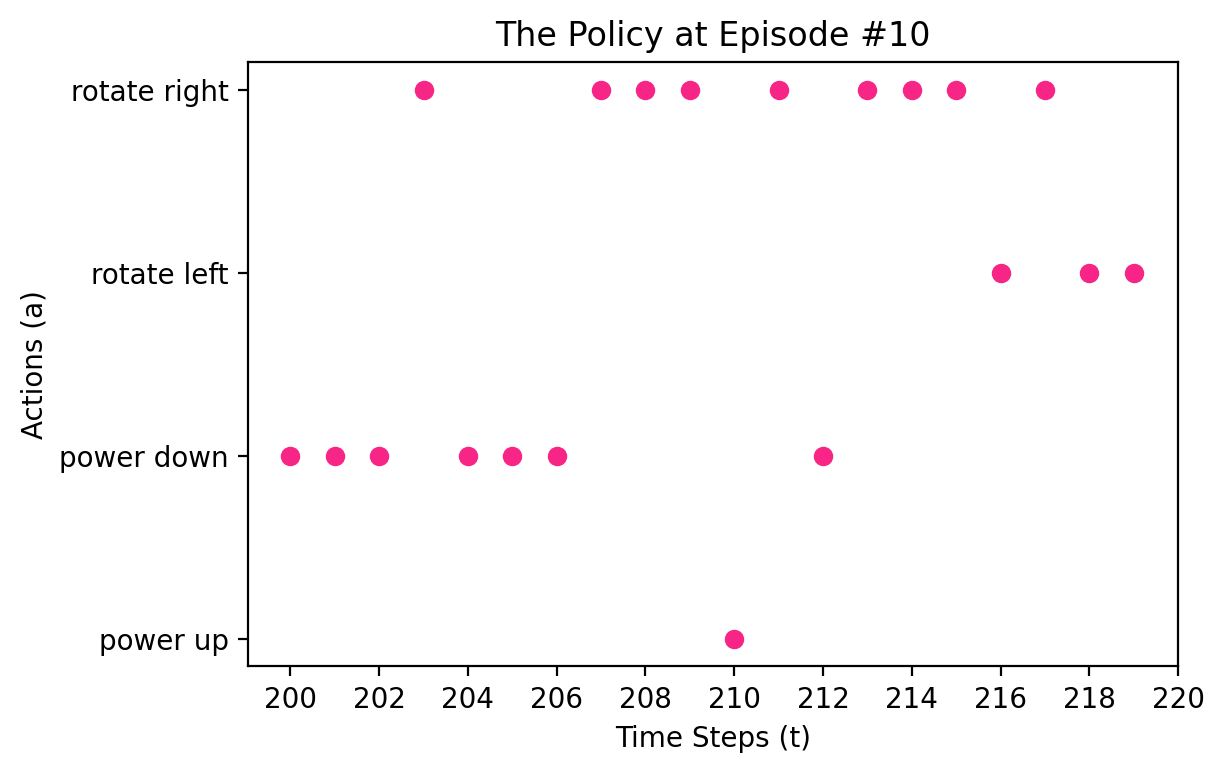

In [90]:
ep = 10
from_t = ep*20
to_t = (ep+1)*20
plt.rcParams['figure.dpi'] = 200
dis_val = actions[from_t:to_t]
plt.scatter(range(from_t,to_t), dis_val , c='#F72585')
#plt.plot(dis_val , c='#B5179E')
#plt.xticks(range(len(dis_val)))
plt.xticks(range(from_t,to_t+1,2))
plt.yticks([0,1,2,3], ['power up', 'power down', 'rotate left', 'rotate right'] )
plt.ylabel('Actions (a)')
plt.title('The Policy at Episode #{0}'.format(ep))
plt.xlabel('Time Steps (t)')

Text(0.5, 0, 'Time Steps (t)')

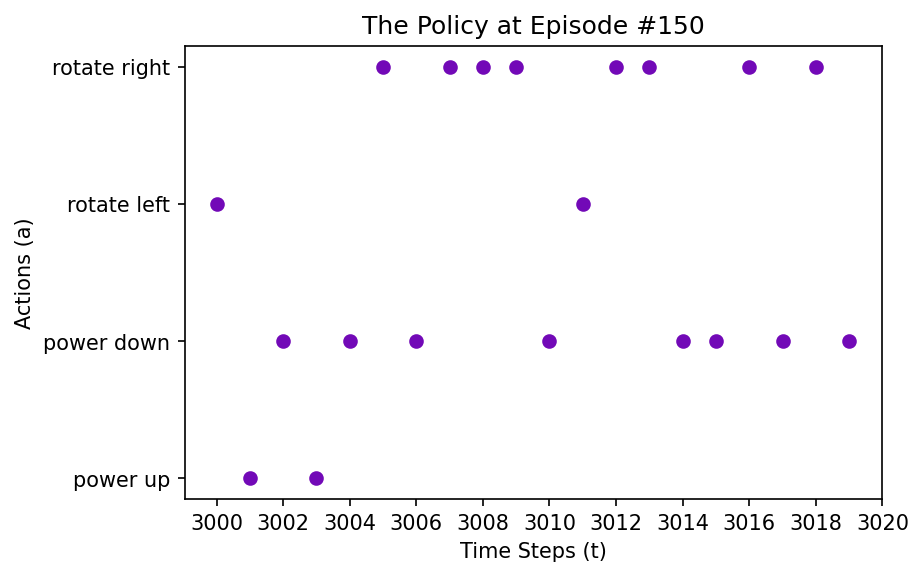

In [91]:
ep = 150
from_t = ep*20
to_t = (ep+1)*20
plt.rcParams['figure.dpi'] = 150
dis_val = actions[from_t:to_t]
plt.scatter(range(from_t,to_t), dis_val , c='#7209B7')
#plt.plot(dis_val , c='#B5179E')
#plt.xticks(range(len(dis_val)))
plt.yticks([0,1,2,3], ['power up', 'power down', 'rotate left', 'rotate right'] )
plt.xticks(range(from_t,to_t+1,2))
plt.ylabel('Actions (a)')
plt.title('The Policy at Episode #{0}'.format(ep))
plt.xlabel('Time Steps (t)')

In [35]:
critic = tf.keras.models.load_model(critic_path, compile=False)

Text(0.5, 0, 'Time Steps (t)')

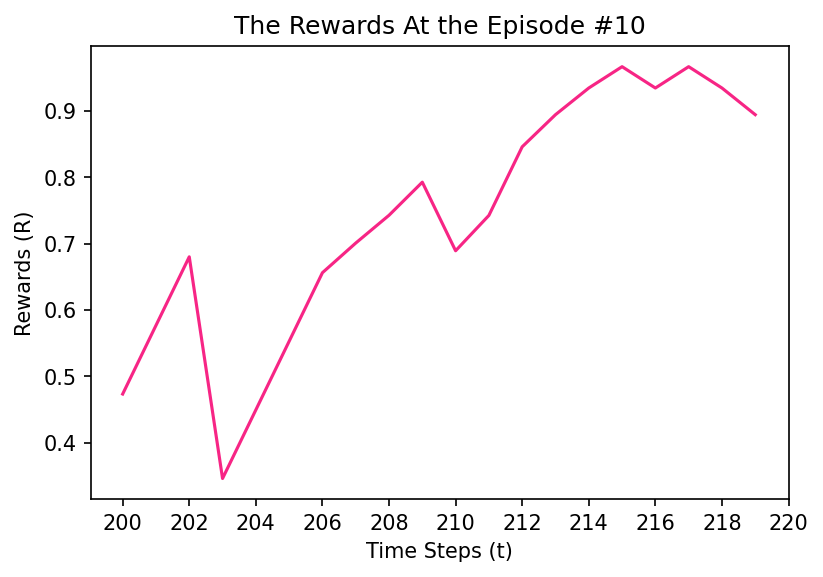

In [89]:
ep = 10
from_t = ep*20
to_t = (ep+1)*20
plt.rcParams['figure.dpi'] = 150
dis_val = rewards[from_t:to_t]
plt.plot(range(from_t,to_t), dis_val , c='#F72585')
#plt.plot(range(from_t,to_t), dis_val , c='#7209B7')
#plt.plot(dis_val , c='#B5179E')7209B7
plt.xticks(range(from_t,to_t+1,2))
plt.ylabel('Rewards (R)')
plt.title('The Rewards At the Episode #{0}'.format(ep))
plt.xlabel('Time Steps (t)')

### Visualise the signals

In [11]:
env = Environment(engine_ip, engine_port)
env.genScene()
signals = []
for us in env.env.UEs:
    signals += us.get_result()
rx_pow = []
rx_delay = []
for i in range(len(signals)):
    rx_pow.append(signals[i]['pow'])
    rx_delay.append(signals[i]['delay'])
#plt.stem(rx_delay, rx_pow)
env.disconnect()

Server: Hello Client 


In [112]:
env.disconnect()

Text(0.5, 0, 'Time Delay (ns)')

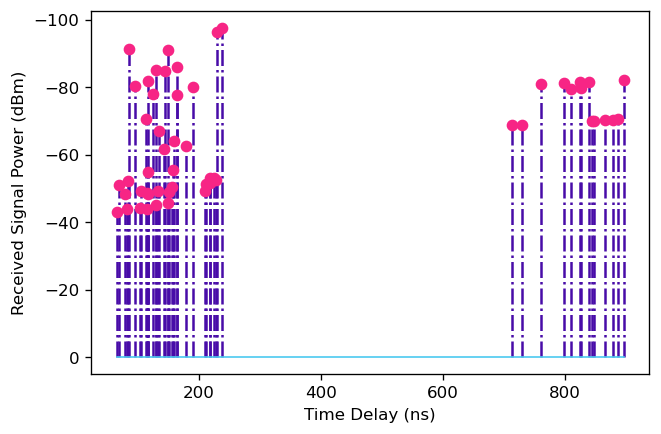

In [40]:
plt.figure()
plt.rcParams['figure.dpi'] = 120
markerline, stemlines, baseline = plt.stem(rx_delay, rx_pow, '.-.')
plt.gca().invert_yaxis()
plt.setp(baseline, 'color', '#4CC9F0', 'linewidth', 1)
plt.setp(markerline, 'color', '#F72585')
plt.setp(stemlines, 'color', '#480CA8')
plt.ylabel('Received Signal Power (dBm)')
plt.xlabel('Time Delay (ns)')